In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import time
from PIL import Image
from sklearn.model_selection import train_test_split

In [2]:
# from google.colab import drive
# drive.mount('/content/drive')

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [4]:
import torch.nn as nn # Contains all the functions we need to to train our network
import torch.nn.functional as F # Contains some additional functions such as activations
from torch.autograd import Variable

In [5]:
from torch.utils.data import Dataset, DataLoader

In [6]:
path = "C:/Users/____/Desktop/DLH_project/healthcare_data"

In [7]:
#load in data - rotations just for ease to look at
guys_X = np.expand_dims(np.rot90(np.load(path+"/subcortical/X_Guys.npy"),axes = (2,3)),1)
guys_Y = np.expand_dims(np.rot90(np.load(path+"/subcortical/y_Guys.npy"),axes = (2,3)),1)

In [210]:
guys_X = np.expand_dims(np.rot90(np.load(path+"/brain_extraction/X_Guys.npy"),axes = (2,3)),1)
guys_Y = np.expand_dims(np.rot90(np.load(path+"/brain_extraction/y_Guys.npy"),axes = (2,3)),1)

In [211]:
# guys_X_wb = None
# guys_Y_wb = None
# guys_X_sub = None
# guys_Y_sub = None

In [146]:
guys_Y.shape

(321, 1, 40, 128, 128)

In [147]:
np.unique(guys_Y).size

5

In [8]:
def centring(data, ax=None):
  """assumes we are reading the data along axis given(1,2,3), with other two constant. if axis none, we normalise each 3d scan"""
  if ax is not None:
    assert(ax in [1,2,3])
    lst = [1,2,3]
    lst.remove(ax)
    axes = tuple(lst)
    return (data - np.mean(data,axis = axes, keepdims = True))/(np.std(data, axis = axes, keepdims = True)+1e-7)
  else:
    return (data - np.mean(data, axis = (1,2,3), keepdims = True))/(np.std(data,axis=(1,2,3),keepdims = True)+1e-7)

In [9]:
def to_one_hot(y):
    """do one-hot encoding"""
    num_classes = np.unique(y).size
    store = np.concatenate([(y==i) for i in range(num_classes)],axis = 1)
    return store

In [10]:
def to_one_hot_fewer(y, indices):
    """do truncated one hot encoding"""
    num_classes = np.unique(y).size
    zeros = (y==0)
    idxs = list(range(1,num_classes))
    l3 = [x for x in idxs if x not in indices]
    for i in l3:
        zeros = np.maximum((y==i),zeros)
    store = np.concatenate([(y==i) for i in indices],axis = 1)
    return np.concatenate([zeros, store],axis=1)

In [11]:
def to_one_hot_single(y,index):
    store = np.concatenate([(y!=index),(y==index)],axis = 1)
    return store.astype(int)

keeping i constant gets sagittal slices, going from L->R or R->L. not sure.

keeping j constant gets axial slices, going from top to bottom.

keeping k constant gets coronal slices, going back to front.

In [12]:
def tupswap(tup,indices):
  """swaps tuple elements at given indices"""
  tup0 = tup[indices[0]]
  tup1 = tup[indices[1]]
  lst = list(tup)
  lst[indices[0]] = tup1
  lst[indices[1]] = tup0
  return tuple(lst)

In [13]:
class integer_numpy_dataset(Dataset):
  """torch dataset for scans. ax corresponds to biological plane. assumes data has been expand_dim'd"""
  def __init__(self, data, target, ax=None):
#    print(data.shape)
#    print(target.shape)
    self.data = torch.from_numpy(data).float()
    self.ax = ax
    if ax is not None:
      assert(ax in [1,2,3])
    self.target = torch.from_numpy(target).float()

  def __len__(self):
    if self.ax is None:
      return self.data.shape[0]
    else:
      assert(self.ax in [1,2,3])
      #print(self.data.shape)
      return self.data.shape[0]*self.data.shape[self.ax+1]

  def __getitem__(self, index):
    #print(index)
    if self.ax is None:
      x = self.data[index]
      y = self.target[index]
    else:
      assert(self.ax in [1,2,3])
#      print(index)
      slice_index, scan_num = divmod(index,self.data.shape[0]) #bug found I think
#      print(scan_num)
#      print(slice_index)
      if self.ax==1:
        x = self.data[scan_num][:,slice_index,:,:]
        y = self.target[scan_num][:,slice_index,:,:]
      elif self.ax==2:
        x = self.data[scan_num][:,:,slice_index,:]
        y = self.target[scan_num][:,:,slice_index,:]
      elif self.ax==3:
        x = self.data[scan_num][:,:,:,slice_index]
        y = self.target[scan_num][:,:,:,slice_index]
        
    return x,y


In [14]:
class numpy_dataset_frac(Dataset):
  """torch dataset for scans. ax corresponds to biological plane. assumes data has been expand_dim'd"""#TODO - turn from multiple scans into multiple channels
  def __init__(self, data, target, ax=None, method="prev"):
    self.data = torch.from_numpy(data).float()
    self.ax = ax
    if ax is not None:
      assert(ax in [1,2,3])
      self.N_scans = self.data.shape[ax+1]
    self.target = torch.from_numpy(target).float()
    self.method=method

  def __len__(self):
    if self.ax is None:
      return self.data.shape[0]
    else:
      assert(self.ax in [1,2,3])
      #print(self.data.shape)
      return self.data.shape[0]*self.data.shape[self.ax+1]

  def __getitem__(self, index):
    #print(index)
    if self.ax is None:
      x = self.data[index]
      y = self.target[index]
    else:
      assert(self.ax in [1,2,3])
      slice_index, scan_num = divmod(index,self.data.shape[0]) #bug found I think
      if self.method=="prev":
        if slice_index>0:

          if self.ax==1:
            x = self.data[scan_num][:,slice_index-1:slice_index+1,:,:]
            x = torch.reshape(x,tupswap(x.shape,(0,self.ax)))
            y = self.target[scan_num][:,slice_index,:,:]
          elif self.ax==2:
            x = self.data[scan_num][:,:,slice_index-1:slice_index+1,:]
            x = torch.reshape(x,tupswap(x.shape,(0,self.ax)))
            y = self.target[scan_num][:,:,slice_index,:]
          elif self.ax==3:
            x = self.data[scan_num][:,:,:,slice_index-1:slice_index+1]
            x = torch.reshape(x,tupswap(x.shape,(0,self.ax)))
            y = self.target[scan_num][:,:,:,slice_index]
        else:

          if self.ax==1:
            x = self.data[scan_num][:,slice_index,:,:]
            x = torch.cat((x,x))
            y = self.target[scan_num][:,slice_index,:,:]
          elif self.ax==2:
            x = self.data[scan_num][:,:,slice_index,:]
            x = torch.cat((x,x))
            y = self.target[scan_num][:,:,slice_index,:]
          elif self.ax==3:
            x = self.data[scan_num][:,:,:,slice_index]
            x = torch.cat((x,x))
            y = self.target[scan_num][:,:,:,slice_index]

      elif self.method == "sandwich":

        if slice_index>0 and slice_index<self.N_scans-1:

          if self.ax==1:
            x = self.data[scan_num][:,slice_index-1:slice_index+2,:,:]
            x = torch.reshape(x,tupswap(x.shape,(0,self.ax)))
            y = self.target[scan_num][:,slice_index,:,:]
          elif self.ax==2:
            x = self.data[scan_num][:,:,slice_index-1:slice_index+2,:]
            x = torch.reshape(x,tupswap(x.shape,(0,self.ax)))
            y = self.target[scan_num][:,:,slice_index,:]
          elif self.ax==3:
            x = self.data[scan_num][:,:,:,slice_index-1:slice_index+2]
            x = torch.reshape(x,tupswap(x.shape,(0,self.ax)))
            y = self.target[scan_num][:,:,:,slice_index]

        elif slice_index==0:

          if self.ax==1:
            x = self.data[scan_num][:,0:2,:,:]#need to check whether this is half open
            x = torch.reshape(x,tupswap(x.shape,(0,self.ax)))
            x = torch.cat((torch.unsqueeze(x[0],0),x))
            y = self.target[scan_num][:,slice_index,:,:]
          elif self.ax==2:
            x = self.data[scan_num][:,:,0:2,:]
            x = torch.reshape(x,tupswap(x.shape,(0,self.ax)))
            x = torch.cat((torch.unsqueeze(x[0],0),x))
            y = self.target[scan_num][:,:,slice_index,:]
          elif self.ax==3:
            x = self.data[scan_num][:,:,:,0:2]
            x = torch.reshape(x,tupswap(x.shape,(0,self.ax)))
            x = torch.cat((torch.unsqueeze(x[0],0),x))
            y = self.target[scan_num][:,:,:,slice_index]

        elif slice_index==self.N_scans-1:

          if self.ax==1:
            x = self.data[scan_num][:,self.N_scans-2:self.N_scans,:,:]#need to check whether this is half open
            x = torch.reshape(x,tupswap(x.shape,(0,self.ax)))
            x = torch.cat((x,torch.unsqueeze(x[1],0)))
            y = self.target[scan_num][:,slice_index,:,:]
          elif self.ax==2:
            x = self.data[scan_num][:,:,self.N_scans-2:self.N_scans,:]
            x = torch.reshape(x,tupswap(x.shape,(0,self.ax)))
            x = torch.cat((x,torch.unsqueeze(x[1],0)))
            y = self.target[scan_num][:,:,slice_index,:]
          elif self.ax==3:
            x = self.data[scan_num][:,:,:,self.N_scans-2:self.N_scans]
            x = torch.reshape(x,tupswap(x.shape,(0,self.ax)))
            x = torch.cat((x,torch.unsqueeze(x[1],0)))
            y = self.target[scan_num][:,:,:,slice_index]
            
      elif self.method == "simpru":
        
        if slice_index>0:

          if self.ax==1:
            x = self.data[scan_num][:,slice_index,:,:]
            z = self.target[scan_num][:,slice_index-1,:,:]
            x = torch.cat((z,x))
            y = self.target[scan_num][:,slice_index,:,:]
          elif self.ax==2:
            x = self.data[scan_num][:,:,slice_index,:]
            z = self.target[scan_num][:,:,slice_index-1,:]
            x = torch.cat((z,x))
            y = self.target[scan_num][:,:,slice_index,:]
          elif self.ax==3:
            x = self.data[scan_num][:,:,:,slice_index]
            z = self.target[scan_num][:,:,:,slice_index-1]
            x = torch.cat((z,x))
            y = self.target[scan_num][:,:,:,slice_index]
        else:

          if self.ax==1:
            x = self.data[scan_num][:,slice_index,:,:]
            z = self.target[scan_num][:,slice_index,:,:]
            x = torch.cat((z,x))
            y = self.target[scan_num][:,slice_index,:,:]
          elif self.ax==2:
            x = self.data[scan_num][:,:,slice_index,:]
            z = self.target[scan_num][:,:,slice_index,:]
            x = torch.cat((z,x))
            y = self.target[scan_num][:,:,slice_index,:]
          elif self.ax==3:
            x = self.data[scan_num][:,:,:,slice_index]
            z = self.target[scan_num][:,:,:,slice_index]
            x = torch.cat((z,x))
            y = self.target[scan_num][:,:,:,slice_index]
        
        
       
    return torch.squeeze(x),y


In [15]:
class FCNet(nn.Module):
    def __init__(self, in_dim=(128,128), hidden_dim=1024, depth = 0):
        super(FCNet, self).__init__()
        self.layers = nn.ModuleList([nn.Linear(in_dim[0]*in_dim[1],hidden_dim),nn.LayerNorm(hidden_dim),nn.ReLU()]+depth*[nn.Linear(hidden_dim,hidden_dim),nn.ReLU()] + 
                                    [nn.Linear(hidden_dim,in_dim[0]*in_dim[1]),nn.ReLU()])
        self.in_dim = in_dim

    def forward(self,x):
        #print(f"{x.shape=}")
        x = torch.flatten(x,1)
        for i in self.layers:
            x = i(x)
        return torch.reshape(x,(x.shape[0],1,self.in_dim[0],self.in_dim[1]))

In [16]:
class UNet(nn.Module):
    def __init__(self, in_channels=1, init_features=4, out_channels=2):
        super(UNet, self).__init__()

        features = init_features
        self.encoder1 = UNet._block(in_channels, init_features, "enc1")
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.encoder2 = UNet._block(init_features, init_features*2, "enc2")
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.bottleneck = UNet._block(features*2, features*4, "bottle")
        self.upconv2 = nn.ConvTranspose2d(features * 4, features * 2, kernel_size=2, stride=2)
        self.decoder2 = UNet._block(features*4, features*2, "dec2")
        self.upconv1 = nn.ConvTranspose2d(features * 2, features, kernel_size=2, stride=2)
        self.decoder1 = UNet._block(features*2, features, "dec1")
        self.conv = nn.Conv2d(in_channels=features, out_channels=out_channels, kernel_size=1)

    def forward(self, x):
        x1 = self.encoder1(x)
        x2 = self.encoder2(self.pool1(x1))
        x3 = self.bottleneck(self.pool2(x2))
        up2 = self.upconv2(x3)
        y2 = self.decoder2(torch.cat((x2,up2), dim = 1))
        up1 = self.upconv1(y2)
        y1 = self.decoder1(torch.cat((x1,up1), dim = 1))
        output = torch.sigmoid(self.conv(y1))
                                        
        return output

    @staticmethod
    def _block(in_channels, features, name):
        return nn.Sequential(
            nn.Conv2d(in_channels, features, 3,1,1, bias = False),
            nn.ReLU(),
            nn.BatchNorm2d(features)
            )

In [17]:
class UNet_3D(nn.Module):
  def __init__(self, in_channels=1, init_features=4, out_channels=2):
        super(UNet_3D, self).__init__()

        features = init_features
        self.encoder1 = UNet_3D._block(in_channels, init_features, "enc1")
        self.pool1 = nn.MaxPool3d(kernel_size=2, stride=2)
        self.encoder2 = UNet_3D._block(init_features, init_features*2, "enc2")
        self.pool2 = nn.MaxPool3d(kernel_size=2, stride=2)
        self.bottleneck = UNet_3D._block(features*2, features*4, "bottle")
        self.upconv2 = nn.ConvTranspose3d(features * 4, features * 2, kernel_size=2, stride=2)
        self.decoder2 = UNet_3D._block(features*4, features*2, "dec2")
        self.upconv1 = nn.ConvTranspose3d(features * 2, features, kernel_size=2, stride=2)
        self.decoder1 = UNet_3D._block(features*2, features, "dec1")
        self.conv = nn.Conv3d(in_channels=features, out_channels=out_channels, kernel_size=1)

  def forward(self, x):
        x1 = self.encoder1(x)
        x2 = self.encoder2(self.pool1(x1))
        x3 = self.bottleneck(self.pool2(x2))
        up2 = self.upconv2(x3)
        y2 = self.decoder2(torch.cat((x2,up2), dim = 1))
        up1 = self.upconv1(y2)
        y1 = self.decoder1(torch.cat((x1,up1), dim = 1))
        output = torch.sigmoid(self.conv(y1))
                                        
        return output

  @staticmethod
  def _block(in_channels, features, name):
        return nn.Sequential(
            nn.Conv3d(in_channels, features, 3,1,1, bias = False),
            nn.ReLU(),
            nn.BatchNorm3d(features)
            )

In [18]:
class RUNet(nn.Module):
  def __init__(self, in_channels=1, init_features=4, out_channels=2, pre_trained=None, token = None, token_shape = None, ax=1):
    super(RUNet,self).__init__()
    
    if token_shape is None:
        token_shape = [40,128,128]
        del(token_shape[ax-1])
        token_shape = tuple(token_shape)

    features=init_features
    if pre_trained is not None:
      self.layers = pre_trained
    else:
      self.layers = UNet(in_channels+out_channels,init_features, out_channels)#i.e. takes in images of given in_channels, and the output of previous slice
    if token is not None:
      self.token = token
    else:
      self.token = nn.parameter.Parameter(torch.rand(tuple([out_channels])+token_shape))
    self.ax = ax
    self.out_channels=out_channels

  def forward(self,x):
    output = None
    #print(f"{x.shape=}")
    for i in range(x.shape[self.ax+1]):#work along an axis
      if self.ax==1:
          part = x[:,:,i,:,:]
      elif self.ax==2:
          part = x[:,:,:,i,:]
      elif self.ax==3:
          part = x[:,:,:,:,i]
      if i==0:
          prev = self.token.expand(tuple([x.shape[0]])+self.token.shape) #do repeat to size N of x
          #print(f"{prev.shape=}") # add token if first entry
      part = torch.cat((prev,part),1) #stack to 3 channels
      res = self.layers(part) #forward pass via UNet
      #print(f"{res.shape=}")
      if output is None:
        output = torch.unsqueeze(res,self.ax+1)
        #print(output.shape)
      else:
        output = torch.cat((output,torch.unsqueeze(res,self.ax+1)),self.ax+1)#build up output
        #print(output.shape)
      prev = res # maybe bug fix
    #print(f"{output.shape=}")
    return torch.Tensor(output)

In [19]:
from sklearn.metrics import accuracy_score

def train(net, dataloader, optim, loss_func, epoch):
    net.train()  #Put the network in train mode
    total_loss = 0
    batches = 0
    start = time.time()
    for batch_idx, (data, target) in enumerate(dataloader):
        data, target = Variable(data), Variable(target)
        batches += 1

        # Training loop
        optim.zero_grad() # to clear gradient in optimizer - this is equivalent to net.zero_grad().

        pred = net(data.to(device))
        loss = loss_func(pred,target.to(device).float())

        loss.backward()
        optim.step()
        
        total_loss += loss
        if batch_idx % 100 == 0: #Report stats every x batches
                print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                    epoch, (batch_idx+1) * len(data), len(dataloader.dataset),
                           100. * (batch_idx+1) / len(dataloader), loss.item()), flush=True)
    av_loss = total_loss / batches
    av_loss = av_loss.detach().cpu().numpy()
    print('\nTraining set: Average loss: {:.4f}'.format(av_loss,  flush=True))
    total_time = time.time() - start
    print('Time taken for epoch = ', total_time)
    return av_loss

def val(net, val_dataloader, optim, loss_func, epoch):
    net.eval()  #Put the model in eval mode
    total_loss = 0    
    batches = 0
    with torch.no_grad():  # So no gradients accumulate
        for batch_idx, (data, target) in enumerate(val_dataloader):
            batches += 1
            data, target = Variable(data), Variable(target)
            # Eval steps
            optim.zero_grad() # to clear gradient in optimizer - this is equivalent to net.zero_grad().

            pred = net(data.to(device))
            loss = loss_func(pred,target.to(device).float())

            total_loss += loss
        av_loss = total_loss / batches
        
    av_loss = av_loss.detach().cpu().numpy()
    print('Validation set: Average loss: {:.4f}'.format(av_loss,  flush=True))
    print('\n')
    return av_loss

def predict(net, test_dataloader):
    pred_store = []
    true_store = []
    batches = 0
    total_loss = 0
    with torch.no_grad():  # So no gradients accumulate
        for batch_idx, (data, target) in enumerate(test_dataloader):
            batches += 1
            data, target = Variable(data), Variable(target)
            # Eval steps
            optim.zero_grad() # to clear gradient in optimizer - this is equivalent to net.zero_grad().

            pred = net(data.to(device))
            loss = class_loss(pred,target.to(device).float())

            total_loss += loss

            pred_store.append(np.argmax(pred.detach().cpu().numpy(), axis=1)) #along each pixel, take argmax - i.e. whether to put 0/1
            true_store.append(np.argmax(target.detach().cpu().numpy(), axis=1))

        av_loss = total_loss / batches
        
    av_loss = av_loss.detach().cpu().numpy()
    pred_store_1 = np.array(pred_store).reshape(-1)
    true_store_1 = np.array(true_store).reshape(-1)
    acc = accuracy_score(pred_store_1, true_store_1)


    print('Test set: Average loss: {:.4f}'.format(av_loss,  flush=True))
    print('Test set: Average Acc: {:.4f}'.format(acc,  flush=True))
    print("\n")
    return pred_store, true_store, av_loss, acc

In [20]:
class dice_loss(nn.Module):
    def __init__(self):
        super(dice_loss, self).__init__()
        self.eps=1e-7

    def forward(self, x, target):
        num_classes = target.shape[1]   # Channels first
        target = target.type(x.type())
        dims = (0,) + tuple(range(2, target.ndimension()))
        intersection = torch.sum(x * target, dims)
        cardinality = torch.sum(x + target, dims)
        dice_loss = (2. * intersection / (cardinality + self.eps)).mean()
        return 1-dice_loss

2D, SUB, SAG

In [214]:
X = centring(guys_X,1) 
Y = to_one_hot(guys_Y)
#Y = to_one_hot_single(guys_Y,1)

In [215]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y,test_size = 0.1)

In [216]:
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size = 0.1)

In [217]:
train_dataset = integer_numpy_dataset(X_train, Y_train,1)
val_dataset = integer_numpy_dataset(X_val, Y_val,1)

In [218]:
train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True, drop_last=True)
val_dataloader = DataLoader(val_dataset, batch_size=16, shuffle=False, drop_last=True)

In [219]:
test_dataset = integer_numpy_dataset(X_test, Y_test,1)
test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=False, drop_last=True)

In [220]:
Y_train.shape

(256, 2, 40, 128, 128)

In [221]:
#train_dataset[500][0].shape

In [222]:
net = UNet(in_channels=1, init_features=4, out_channels=2).to(device)
print('Trainable params: ', net.parameters())

Trainable params:  <generator object Module.parameters at 0x00000243024194D0>


Train Epoch: 1 [16/10240 (0%)]	Loss: 0.506392
Train Epoch: 1 [1616/10240 (16%)]	Loss: 0.037808
Train Epoch: 1 [3216/10240 (31%)]	Loss: 0.028638
Train Epoch: 1 [4816/10240 (47%)]	Loss: 0.027562
Train Epoch: 1 [6416/10240 (63%)]	Loss: 0.026831
Train Epoch: 1 [8016/10240 (78%)]	Loss: 0.024283
Train Epoch: 1 [9616/10240 (94%)]	Loss: 0.030458

Training set: Average loss: 0.0466
Time taken for epoch =  15.1966392993927
Validation set: Average loss: 0.0311


Train Epoch: 2 [16/10240 (0%)]	Loss: 0.022664
Train Epoch: 2 [1616/10240 (16%)]	Loss: 0.019993
Train Epoch: 2 [3216/10240 (31%)]	Loss: 0.021604
Train Epoch: 2 [4816/10240 (47%)]	Loss: 0.032161
Train Epoch: 2 [6416/10240 (63%)]	Loss: 0.028625
Train Epoch: 2 [8016/10240 (78%)]	Loss: 0.044371
Train Epoch: 2 [9616/10240 (94%)]	Loss: 0.027959

Training set: Average loss: 0.0257
Time taken for epoch =  8.585040807723999
Validation set: Average loss: 0.0269


Train Epoch: 3 [16/10240 (0%)]	Loss: 0.027769
Train Epoch: 3 [1616/10240 (16%)]	Loss: 0

Validation set: Average loss: 0.0213


Train Epoch: 19 [16/10240 (0%)]	Loss: 0.017010
Train Epoch: 19 [1616/10240 (16%)]	Loss: 0.021029
Train Epoch: 19 [3216/10240 (31%)]	Loss: 0.017764
Train Epoch: 19 [4816/10240 (47%)]	Loss: 0.019252
Train Epoch: 19 [6416/10240 (63%)]	Loss: 0.022814
Train Epoch: 19 [8016/10240 (78%)]	Loss: 0.021469
Train Epoch: 19 [9616/10240 (94%)]	Loss: 0.018385

Training set: Average loss: 0.0195
Time taken for epoch =  8.630918264389038
Validation set: Average loss: 0.0215


Train Epoch: 20 [16/10240 (0%)]	Loss: 0.016000
Train Epoch: 20 [1616/10240 (16%)]	Loss: 0.019684
Train Epoch: 20 [3216/10240 (31%)]	Loss: 0.023174
Train Epoch: 20 [4816/10240 (47%)]	Loss: 0.019488
Train Epoch: 20 [6416/10240 (63%)]	Loss: 0.017958
Train Epoch: 20 [8016/10240 (78%)]	Loss: 0.017340
Train Epoch: 20 [9616/10240 (94%)]	Loss: 0.017756

Training set: Average loss: 0.0188
Time taken for epoch =  8.381584167480469
Validation set: Average loss: 0.0217


(2, 20)


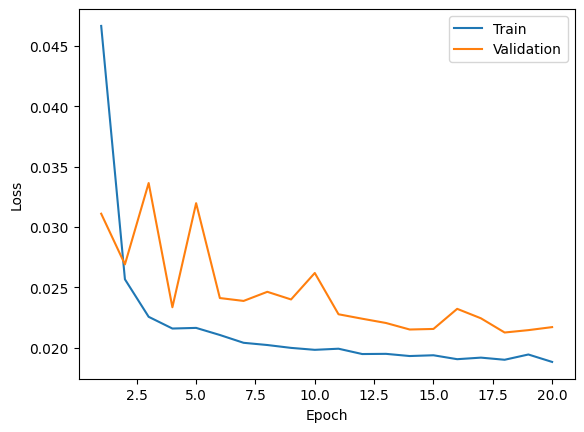

In [223]:
class_loss = dice_loss()
optim = torch.optim.Adam(net.parameters(), lr = 0.01)

losses = []
max_epochs = 20
for epoch in range(1, max_epochs+1):
    train_loss = train(net, train_dataloader, optim, class_loss, epoch)
    val_loss = val(net, val_dataloader, optim, class_loss, epoch)
    losses.append([train_loss, val_loss])

losses = np.array(losses).T
print(losses.shape)
its = np.linspace(1, max_epochs, max_epochs)

plt.figure()
plt.plot(its, losses[0,:])
plt.plot(its, losses[1,:])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'])

In [224]:
pred, true, test_loss, test_acc = predict(net, test_dataloader)

Test set: Average loss: 0.0191
Test set: Average Acc: 0.9831




2D, SUB, AX

In [225]:
X = centring(guys_X,2) 
Y = to_one_hot(guys_Y)
#Y = to_one_hot_single(guys_Y,1)

In [226]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y,test_size = 0.1)

In [227]:
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size = 0.1)

In [228]:
train_dataset = integer_numpy_dataset(X_train, Y_train,2)
val_dataset = integer_numpy_dataset(X_val, Y_val,2)

In [229]:
train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True, drop_last=True)
val_dataloader = DataLoader(val_dataset, batch_size=16, shuffle=False, drop_last=True)

In [230]:
test_dataset = integer_numpy_dataset(X_test, Y_test,2)
test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=False, drop_last=True)

In [231]:
Y_train.shape

(256, 2, 40, 128, 128)

In [232]:
#train_dataset[500][0].shape

In [233]:
net = UNet(in_channels=1, init_features=4, out_channels=2).to(device)
print('Trainable params: ', net.parameters())

Trainable params:  <generator object Module.parameters at 0x0000024302418A50>


Train Epoch: 1 [16/32768 (0%)]	Loss: 0.542591
Train Epoch: 1 [1616/32768 (5%)]	Loss: 0.063095
Train Epoch: 1 [3216/32768 (10%)]	Loss: 0.053141
Train Epoch: 1 [4816/32768 (15%)]	Loss: 0.067577
Train Epoch: 1 [6416/32768 (20%)]	Loss: 0.055047
Train Epoch: 1 [8016/32768 (24%)]	Loss: 0.051541
Train Epoch: 1 [9616/32768 (29%)]	Loss: 0.066943
Train Epoch: 1 [11216/32768 (34%)]	Loss: 0.053724
Train Epoch: 1 [12816/32768 (39%)]	Loss: 0.034883
Train Epoch: 1 [14416/32768 (44%)]	Loss: 0.029090
Train Epoch: 1 [16016/32768 (49%)]	Loss: 0.032330
Train Epoch: 1 [17616/32768 (54%)]	Loss: 0.044111
Train Epoch: 1 [19216/32768 (59%)]	Loss: 0.055661
Train Epoch: 1 [20816/32768 (64%)]	Loss: 0.035656
Train Epoch: 1 [22416/32768 (68%)]	Loss: 0.034514
Train Epoch: 1 [24016/32768 (73%)]	Loss: 0.029052
Train Epoch: 1 [25616/32768 (78%)]	Loss: 0.050873
Train Epoch: 1 [27216/32768 (83%)]	Loss: 0.028505
Train Epoch: 1 [28816/32768 (88%)]	Loss: 0.039077
Train Epoch: 1 [30416/32768 (93%)]	Loss: 0.040960
Train Epoch

Train Epoch: 8 [4816/32768 (15%)]	Loss: 0.026841
Train Epoch: 8 [6416/32768 (20%)]	Loss: 0.023436
Train Epoch: 8 [8016/32768 (24%)]	Loss: 0.025590
Train Epoch: 8 [9616/32768 (29%)]	Loss: 0.029549
Train Epoch: 8 [11216/32768 (34%)]	Loss: 0.021341
Train Epoch: 8 [12816/32768 (39%)]	Loss: 0.024583
Train Epoch: 8 [14416/32768 (44%)]	Loss: 0.020199
Train Epoch: 8 [16016/32768 (49%)]	Loss: 0.030746
Train Epoch: 8 [17616/32768 (54%)]	Loss: 0.037870
Train Epoch: 8 [19216/32768 (59%)]	Loss: 0.038567
Train Epoch: 8 [20816/32768 (64%)]	Loss: 0.028176
Train Epoch: 8 [22416/32768 (68%)]	Loss: 0.021234
Train Epoch: 8 [24016/32768 (73%)]	Loss: 0.029920
Train Epoch: 8 [25616/32768 (78%)]	Loss: 0.037620
Train Epoch: 8 [27216/32768 (83%)]	Loss: 0.025467
Train Epoch: 8 [28816/32768 (88%)]	Loss: 0.029198
Train Epoch: 8 [30416/32768 (93%)]	Loss: 0.027873
Train Epoch: 8 [32016/32768 (98%)]	Loss: 0.020342

Training set: Average loss: 0.0274
Time taken for epoch =  17.01193380355835
Validation set: Average lo

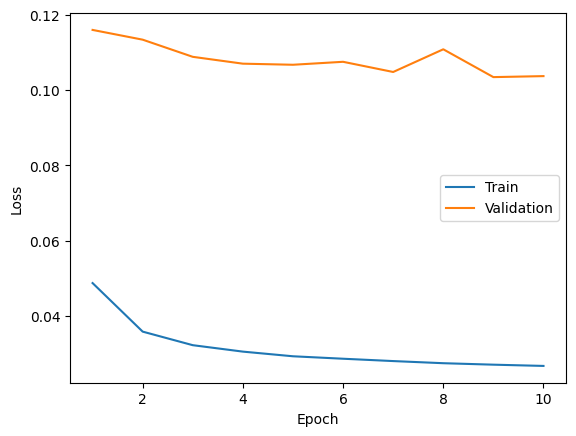

In [234]:
class_loss = dice_loss()
optim = torch.optim.Adam(net.parameters(), lr = 0.01)

losses = []
max_epochs = 10
for epoch in range(1, max_epochs+1):
    train_loss = train(net, train_dataloader, optim, class_loss, epoch)
    val_loss = val(net, val_dataloader, optim, class_loss, epoch)
    losses.append([train_loss, val_loss])

losses = np.array(losses).T
print(losses.shape)
its = np.linspace(1, max_epochs, max_epochs)

plt.figure()
plt.plot(its, losses[0,:])
plt.plot(its, losses[1,:])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'])

In [235]:
pred, true, test_loss, test_acc = predict(net, test_dataloader)

Test set: Average loss: 0.0933
Test set: Average Acc: 0.9777




2D, SUB, COR

In [236]:
X = centring(guys_X,3) 
Y = to_one_hot(guys_Y)
#Y = to_one_hot_single(guys_Y,1)

In [237]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y,test_size = 0.1)

In [238]:
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size = 0.1)

In [239]:
train_dataset = integer_numpy_dataset(X_train, Y_train,3)
val_dataset = integer_numpy_dataset(X_val, Y_val,3)

In [240]:
train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True, drop_last=True)
val_dataloader = DataLoader(val_dataset, batch_size=16, shuffle=False, drop_last=True)

In [241]:
test_dataset = integer_numpy_dataset(X_test, Y_test,3)
test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=False, drop_last=True)

In [242]:
Y_train.shape

(256, 2, 40, 128, 128)

In [243]:
#train_dataset[500][0].shape

In [244]:
net = UNet(in_channels=1, init_features=4, out_channels=2).to(device)
print('Trainable params: ', net.parameters())

Trainable params:  <generator object Module.parameters at 0x000002430241A5E0>


Train Epoch: 1 [16/32768 (0%)]	Loss: 0.510038
Train Epoch: 1 [1616/32768 (5%)]	Loss: 0.134638
Train Epoch: 1 [3216/32768 (10%)]	Loss: 0.059738
Train Epoch: 1 [4816/32768 (15%)]	Loss: 0.048722
Train Epoch: 1 [6416/32768 (20%)]	Loss: 0.041155
Train Epoch: 1 [8016/32768 (24%)]	Loss: 0.107829
Train Epoch: 1 [9616/32768 (29%)]	Loss: 0.046053
Train Epoch: 1 [11216/32768 (34%)]	Loss: 0.060039
Train Epoch: 1 [12816/32768 (39%)]	Loss: 0.040703
Train Epoch: 1 [14416/32768 (44%)]	Loss: 0.070408
Train Epoch: 1 [16016/32768 (49%)]	Loss: 0.048484
Train Epoch: 1 [17616/32768 (54%)]	Loss: 0.035243
Train Epoch: 1 [19216/32768 (59%)]	Loss: 0.041705
Train Epoch: 1 [20816/32768 (64%)]	Loss: 0.063648
Train Epoch: 1 [22416/32768 (68%)]	Loss: 0.065960
Train Epoch: 1 [24016/32768 (73%)]	Loss: 0.140731
Train Epoch: 1 [25616/32768 (78%)]	Loss: 0.089500
Train Epoch: 1 [27216/32768 (83%)]	Loss: 0.052150
Train Epoch: 1 [28816/32768 (88%)]	Loss: 0.059835
Train Epoch: 1 [30416/32768 (93%)]	Loss: 0.045984
Train Epoch

Train Epoch: 8 [3216/32768 (10%)]	Loss: 0.034144
Train Epoch: 8 [4816/32768 (15%)]	Loss: 0.031382
Train Epoch: 8 [6416/32768 (20%)]	Loss: 0.031654
Train Epoch: 8 [8016/32768 (24%)]	Loss: 0.036362
Train Epoch: 8 [9616/32768 (29%)]	Loss: 0.048654
Train Epoch: 8 [11216/32768 (34%)]	Loss: 0.035621
Train Epoch: 8 [12816/32768 (39%)]	Loss: 0.029343
Train Epoch: 8 [14416/32768 (44%)]	Loss: 0.041825
Train Epoch: 8 [16016/32768 (49%)]	Loss: 0.034035
Train Epoch: 8 [17616/32768 (54%)]	Loss: 0.027775
Train Epoch: 8 [19216/32768 (59%)]	Loss: 0.043760
Train Epoch: 8 [20816/32768 (64%)]	Loss: 0.037441
Train Epoch: 8 [22416/32768 (68%)]	Loss: 0.028425
Train Epoch: 8 [24016/32768 (73%)]	Loss: 0.030908
Train Epoch: 8 [25616/32768 (78%)]	Loss: 0.038978
Train Epoch: 8 [27216/32768 (83%)]	Loss: 0.031638
Train Epoch: 8 [28816/32768 (88%)]	Loss: 0.024774
Train Epoch: 8 [30416/32768 (93%)]	Loss: 0.027665
Train Epoch: 8 [32016/32768 (98%)]	Loss: 0.038858

Training set: Average loss: 0.0365
Time taken for epoc

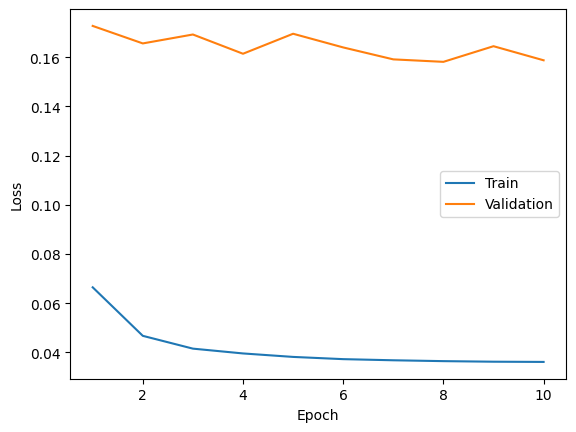

In [245]:
class_loss = dice_loss()
optim = torch.optim.Adam(net.parameters(), lr = 0.01)

losses = []
max_epochs = 10
for epoch in range(1, max_epochs+1):
    train_loss = train(net, train_dataloader, optim, class_loss, epoch)
    val_loss = val(net, val_dataloader, optim, class_loss, epoch)
    losses.append([train_loss, val_loss])

losses = np.array(losses).T
print(losses.shape)
its = np.linspace(1, max_epochs, max_epochs)

plt.figure()
plt.plot(its, losses[0,:])
plt.plot(its, losses[1,:])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'])

In [246]:
pred, true, test_loss, test_acc = predict(net, test_dataloader)

Test set: Average loss: 0.1630
Test set: Average Acc: 0.9714




now for 2.5D SUNet SAG

In [247]:
X = centring(guys_X,1) 
Y = to_one_hot(guys_Y)
#Y = to_one_hot_single(guys_Y,1)

In [248]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y,test_size = 0.1)

In [249]:
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size = 0.1)

In [250]:
train_dataset = numpy_dataset_frac(X_train, Y_train,1,"sandwich")
val_dataset = numpy_dataset_frac(X_val, Y_val,1,"sandwich")

In [251]:
train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True, drop_last=True)
val_dataloader = DataLoader(val_dataset, batch_size=16, shuffle=False, drop_last=True)

In [252]:
test_dataset = numpy_dataset_frac(X_test, Y_test,1,"sandwich")
test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=False, drop_last=True)

In [253]:
Y_train.shape

(256, 2, 40, 128, 128)

In [254]:
train_dataset[500][0].shape

torch.Size([3, 128, 128])

In [255]:
net = UNet(in_channels=3, init_features=4, out_channels=2).to(device)
print('Trainable params: ', net.parameters())

Trainable params:  <generator object Module.parameters at 0x000002430241AE30>


Train Epoch: 1 [16/10240 (0%)]	Loss: 0.478972
Train Epoch: 1 [1616/10240 (16%)]	Loss: 0.040549
Train Epoch: 1 [3216/10240 (31%)]	Loss: 0.032790
Train Epoch: 1 [4816/10240 (47%)]	Loss: 0.024953
Train Epoch: 1 [6416/10240 (63%)]	Loss: 0.038735
Train Epoch: 1 [8016/10240 (78%)]	Loss: 0.028497
Train Epoch: 1 [9616/10240 (94%)]	Loss: 0.021566

Training set: Average loss: 0.0451
Time taken for epoch =  7.999637126922607
Validation set: Average loss: 0.0278


Train Epoch: 2 [16/10240 (0%)]	Loss: 0.031694
Train Epoch: 2 [1616/10240 (16%)]	Loss: 0.022106
Train Epoch: 2 [3216/10240 (31%)]	Loss: 0.022430
Train Epoch: 2 [4816/10240 (47%)]	Loss: 0.019085
Train Epoch: 2 [6416/10240 (63%)]	Loss: 0.023079
Train Epoch: 2 [8016/10240 (78%)]	Loss: 0.022871
Train Epoch: 2 [9616/10240 (94%)]	Loss: 0.022156

Training set: Average loss: 0.0219
Time taken for epoch =  7.429131746292114
Validation set: Average loss: 0.0222


Train Epoch: 3 [16/10240 (0%)]	Loss: 0.022796
Train Epoch: 3 [1616/10240 (16%)]	Loss: 

Validation set: Average loss: 0.0186


Train Epoch: 19 [16/10240 (0%)]	Loss: 0.014752
Train Epoch: 19 [1616/10240 (16%)]	Loss: 0.017032
Train Epoch: 19 [3216/10240 (31%)]	Loss: 0.016155
Train Epoch: 19 [4816/10240 (47%)]	Loss: 0.014054
Train Epoch: 19 [6416/10240 (63%)]	Loss: 0.016674
Train Epoch: 19 [8016/10240 (78%)]	Loss: 0.017860
Train Epoch: 19 [9616/10240 (94%)]	Loss: 0.015127

Training set: Average loss: 0.0172
Time taken for epoch =  7.454065561294556
Validation set: Average loss: 0.0183


Train Epoch: 20 [16/10240 (0%)]	Loss: 0.017692
Train Epoch: 20 [1616/10240 (16%)]	Loss: 0.016019
Train Epoch: 20 [3216/10240 (31%)]	Loss: 0.014620
Train Epoch: 20 [4816/10240 (47%)]	Loss: 0.016430
Train Epoch: 20 [6416/10240 (63%)]	Loss: 0.015849
Train Epoch: 20 [8016/10240 (78%)]	Loss: 0.015110
Train Epoch: 20 [9616/10240 (94%)]	Loss: 0.017294

Training set: Average loss: 0.0172
Time taken for epoch =  7.535846948623657
Validation set: Average loss: 0.0189


(2, 20)


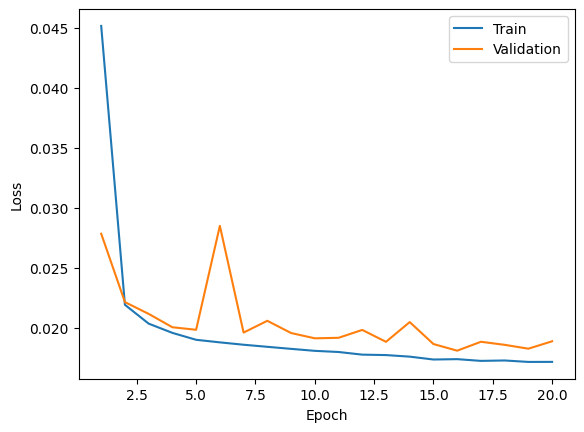

In [256]:
class_loss = dice_loss()
optim = torch.optim.Adam(net.parameters(), lr = 0.01)

losses = []
max_epochs = 20
for epoch in range(1, max_epochs+1):
    train_loss = train(net, train_dataloader, optim, class_loss, epoch)
    val_loss = val(net, val_dataloader, optim, class_loss, epoch)
    losses.append([train_loss, val_loss])

losses = np.array(losses).T
print(losses.shape)
its = np.linspace(1, max_epochs, max_epochs)

plt.figure()
plt.plot(its, losses[0,:])
plt.plot(its, losses[1,:])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'])

In [257]:
pred, true, test_loss, test_acc = predict(net, test_dataloader)

Test set: Average loss: 0.0171
Test set: Average Acc: 0.9848




now for 2.5D SUNet AX

In [21]:
X = centring(guys_X,2) 
#Y = to_one_hot(guys_Y)
Y = to_one_hot_single(guys_Y,1)

In [22]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y,test_size = 0.1)

In [23]:
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size = 0.1)

In [24]:
train_dataset = numpy_dataset_frac(X_train, Y_train,2,"sandwich")
val_dataset = numpy_dataset_frac(X_val, Y_val,2,"sandwich")

In [25]:
train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True, drop_last=True)
val_dataloader = DataLoader(val_dataset, batch_size=16, shuffle=False, drop_last=True)

In [26]:
test_dataset = numpy_dataset_frac(X_test, Y_test,2,"sandwich")
test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=False, drop_last=True)

In [27]:
Y_train.shape

(259, 2, 40, 128, 128)

In [28]:
#train_dataset[500][0].shape

In [29]:
net = UNet(in_channels=3, init_features=4, out_channels=2).to(device)
print('Trainable params: ', net.parameters())

Trainable params:  <generator object Module.parameters at 0x0000020469A3B0D0>


Train Epoch: 1 [16/33152 (0%)]	Loss: 0.647859
Train Epoch: 1 [1616/33152 (5%)]	Loss: 0.504414
Train Epoch: 1 [3216/33152 (10%)]	Loss: 0.501973
Train Epoch: 1 [4816/33152 (15%)]	Loss: 0.288238
Train Epoch: 1 [6416/33152 (19%)]	Loss: 0.501550
Train Epoch: 1 [8016/33152 (24%)]	Loss: 0.404843
Train Epoch: 1 [9616/33152 (29%)]	Loss: 0.295492
Train Epoch: 1 [11216/33152 (34%)]	Loss: 0.259463
Train Epoch: 1 [12816/33152 (39%)]	Loss: 0.500884
Train Epoch: 1 [14416/33152 (43%)]	Loss: 0.196635
Train Epoch: 1 [16016/33152 (48%)]	Loss: 0.137203
Train Epoch: 1 [17616/33152 (53%)]	Loss: 0.110764
Train Epoch: 1 [19216/33152 (58%)]	Loss: 0.087107
Train Epoch: 1 [20816/33152 (63%)]	Loss: 0.131389
Train Epoch: 1 [22416/33152 (68%)]	Loss: 0.243796
Train Epoch: 1 [24016/33152 (72%)]	Loss: 0.076730
Train Epoch: 1 [25616/33152 (77%)]	Loss: 0.092381
Train Epoch: 1 [27216/33152 (82%)]	Loss: 0.247882
Train Epoch: 1 [28816/33152 (87%)]	Loss: 0.366180
Train Epoch: 1 [30416/33152 (92%)]	Loss: 0.181891
Train Epoch

Train Epoch: 8 [4816/33152 (15%)]	Loss: 0.128071
Train Epoch: 8 [6416/33152 (19%)]	Loss: 0.113255
Train Epoch: 8 [8016/33152 (24%)]	Loss: 0.496143
Train Epoch: 8 [9616/33152 (29%)]	Loss: 0.138025
Train Epoch: 8 [11216/33152 (34%)]	Loss: 0.500487
Train Epoch: 8 [12816/33152 (39%)]	Loss: 0.074079
Train Epoch: 8 [14416/33152 (43%)]	Loss: 0.078934
Train Epoch: 8 [16016/33152 (48%)]	Loss: 0.130804
Train Epoch: 8 [17616/33152 (53%)]	Loss: 0.085653
Train Epoch: 8 [19216/33152 (58%)]	Loss: 0.106004
Train Epoch: 8 [20816/33152 (63%)]	Loss: 0.071953
Train Epoch: 8 [22416/33152 (68%)]	Loss: 0.082635
Train Epoch: 8 [24016/33152 (72%)]	Loss: 0.500473
Train Epoch: 8 [25616/33152 (77%)]	Loss: 0.101296
Train Epoch: 8 [27216/33152 (82%)]	Loss: 0.047649
Train Epoch: 8 [28816/33152 (87%)]	Loss: 0.080356
Train Epoch: 8 [30416/33152 (92%)]	Loss: 0.500526
Train Epoch: 8 [32016/33152 (97%)]	Loss: 0.107077

Training set: Average loss: 0.1527
Time taken for epoch =  19.864609479904175
Validation set: Average l

Train Epoch: 15 [4816/33152 (15%)]	Loss: 0.088638
Train Epoch: 15 [6416/33152 (19%)]	Loss: 0.123730
Train Epoch: 15 [8016/33152 (24%)]	Loss: 0.052358
Train Epoch: 15 [9616/33152 (29%)]	Loss: 0.092597
Train Epoch: 15 [11216/33152 (34%)]	Loss: 0.075103
Train Epoch: 15 [12816/33152 (39%)]	Loss: 0.059264
Train Epoch: 15 [14416/33152 (43%)]	Loss: 0.092614
Train Epoch: 15 [16016/33152 (48%)]	Loss: 0.077716
Train Epoch: 15 [17616/33152 (53%)]	Loss: 0.077580
Train Epoch: 15 [19216/33152 (58%)]	Loss: 0.500055
Train Epoch: 15 [20816/33152 (63%)]	Loss: 0.117594
Train Epoch: 15 [22416/33152 (68%)]	Loss: 0.070153
Train Epoch: 15 [24016/33152 (72%)]	Loss: 0.072864
Train Epoch: 15 [25616/33152 (77%)]	Loss: 0.137379
Train Epoch: 15 [27216/33152 (82%)]	Loss: 0.190217
Train Epoch: 15 [28816/33152 (87%)]	Loss: 0.091748
Train Epoch: 15 [30416/33152 (92%)]	Loss: 0.131985
Train Epoch: 15 [32016/33152 (97%)]	Loss: 0.081720

Training set: Average loss: 0.1527
Time taken for epoch =  20.767951726913452
Validat

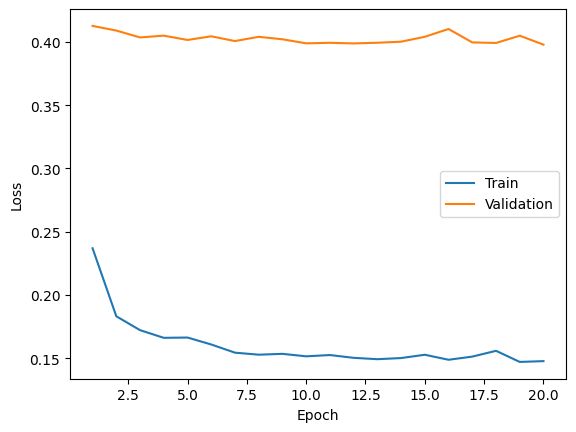

In [30]:
class_loss = dice_loss()
optim = torch.optim.Adam(net.parameters(), lr = 0.01)

losses = []
max_epochs = 20
for epoch in range(1, max_epochs+1):
    train_loss = train(net, train_dataloader, optim, class_loss, epoch)
    val_loss = val(net, val_dataloader, optim, class_loss, epoch)
    losses.append([train_loss, val_loss])

losses = np.array(losses).T
print(losses.shape)
its = np.linspace(1, max_epochs, max_epochs)

plt.figure()
plt.plot(its, losses[0,:])
plt.plot(its, losses[1,:])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'])

In [31]:
pred, true, test_loss, test_acc = predict(net, test_dataloader)

Test set: Average loss: 0.3843
Test set: Average Acc: 0.9976




In [38]:
net.eval()

UNet(
  (encoder1): Sequential(
    (0): Conv2d(3, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): ReLU()
    (2): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (encoder2): Sequential(
    (0): Conv2d(4, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): ReLU()
    (2): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (bottleneck): Sequential(
    (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): ReLU()
    (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (upconv2): ConvTranspose2d(16, 8, kernel_size=(2, 2), stride=(2, 2))
  (decoder2): Sequential(
    (0): Conv2d(16, 8, kernel_size=(3, 3), stride=(1, 1), paddin

In [36]:
test_dataset[0][0].shape

torch.Size([3, 40, 128])

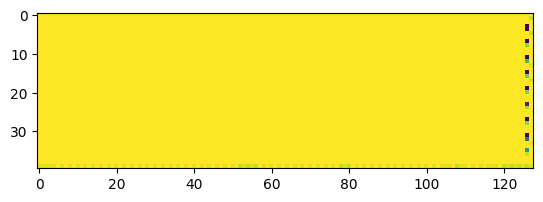

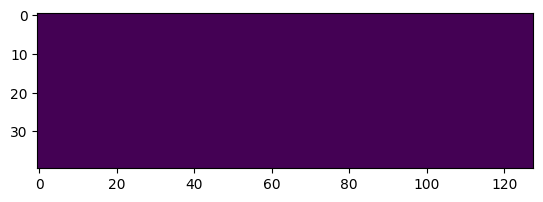

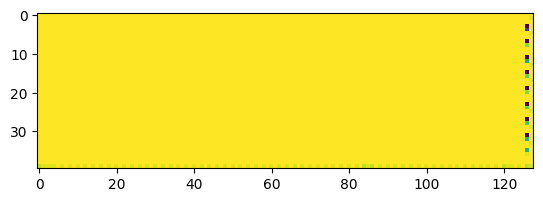

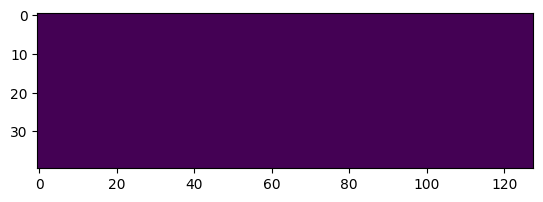

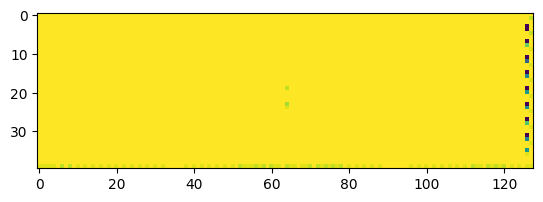

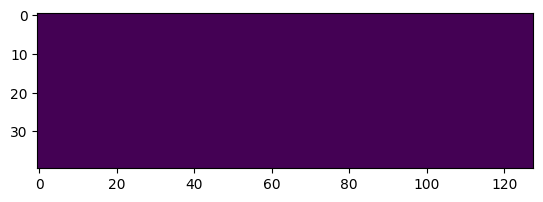

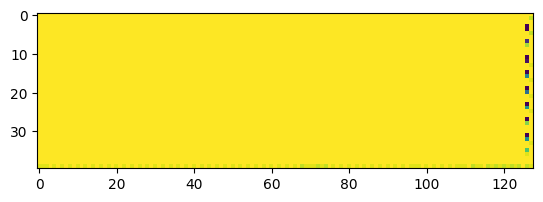

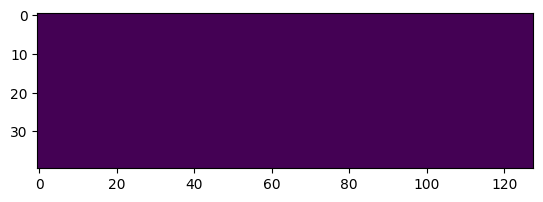

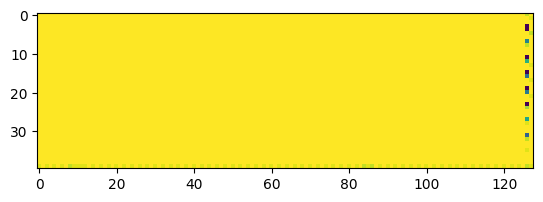

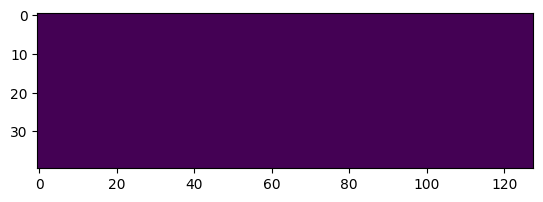

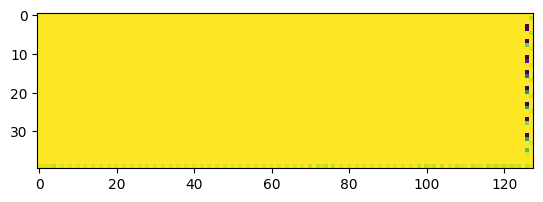

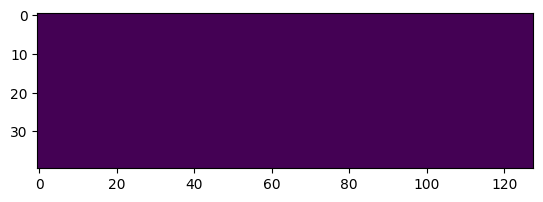

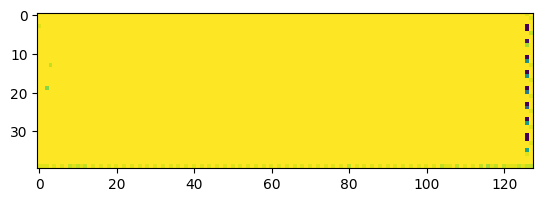

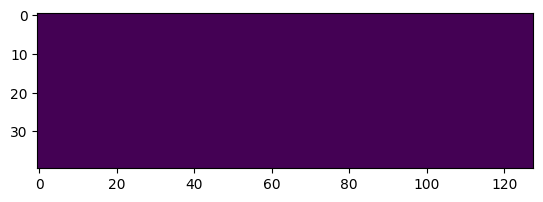

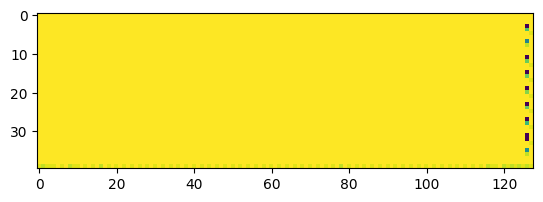

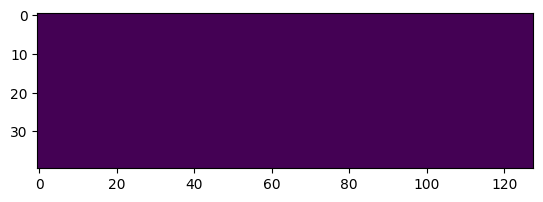

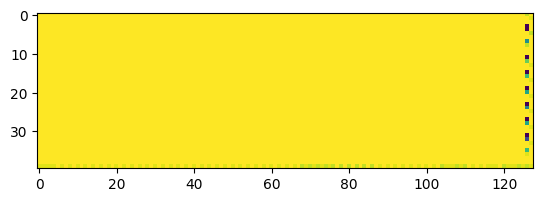

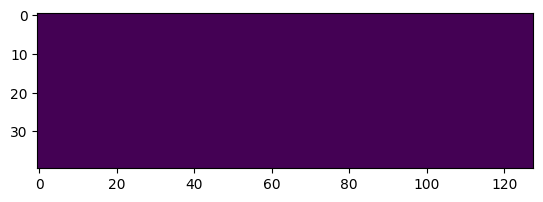

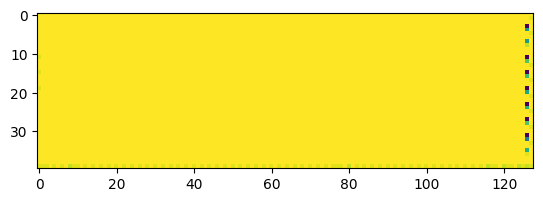

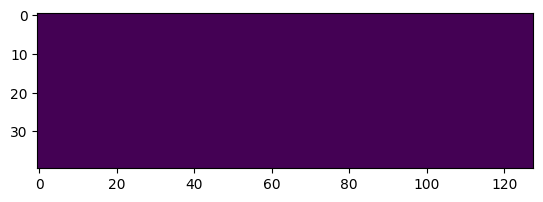

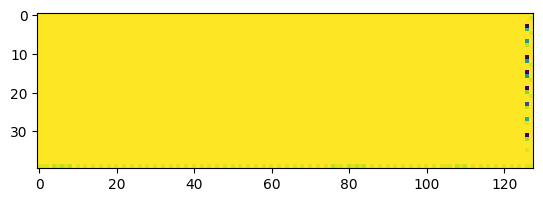

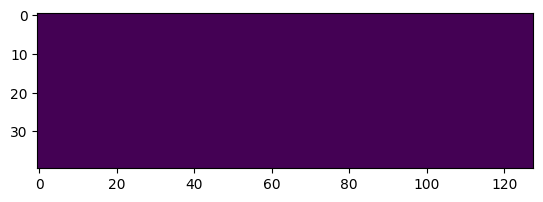

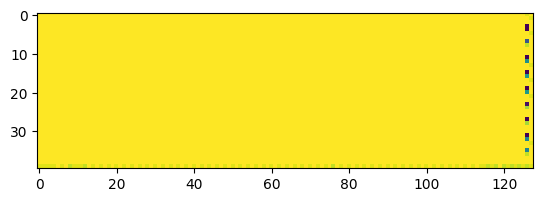

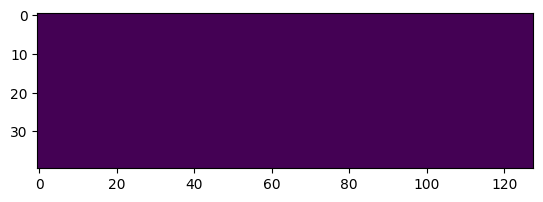

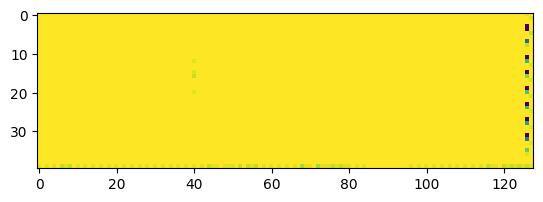

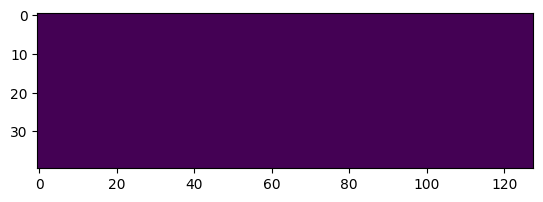

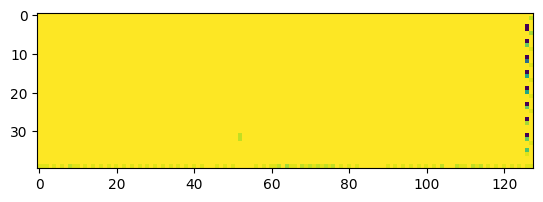

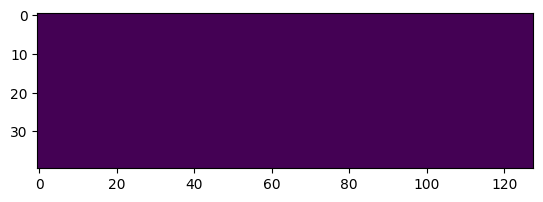

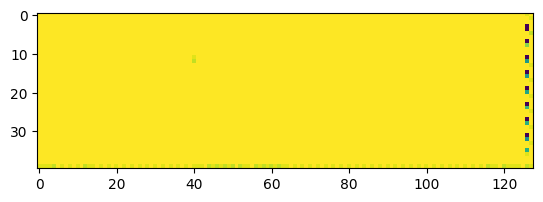

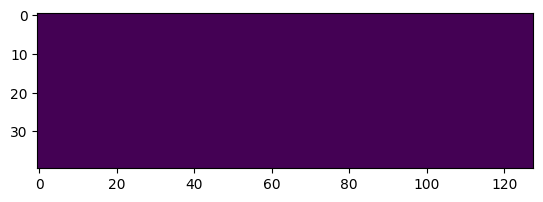

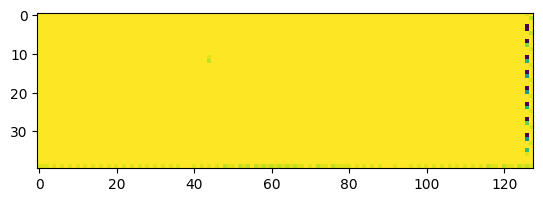

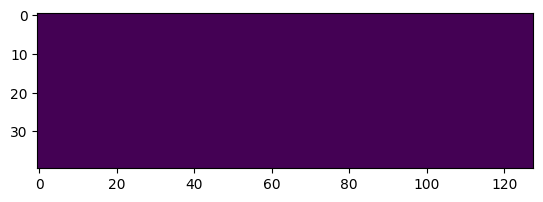

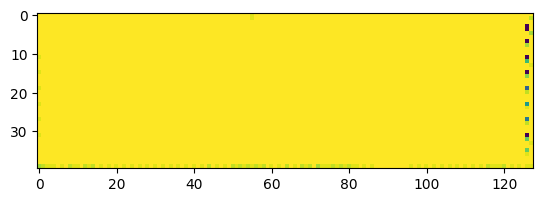

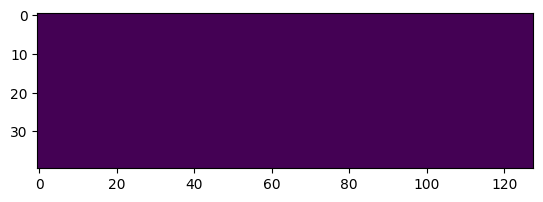

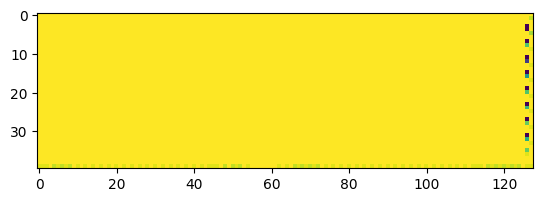

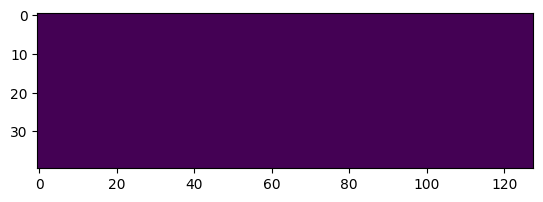

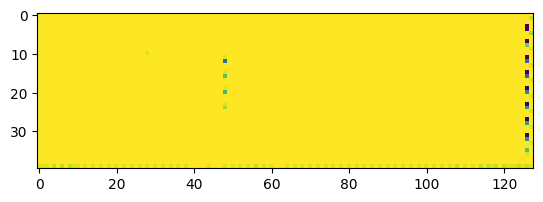

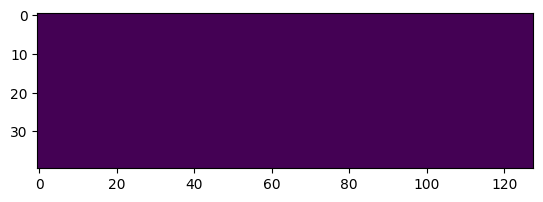

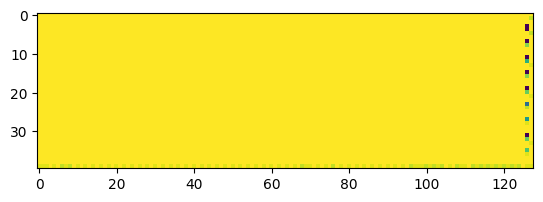

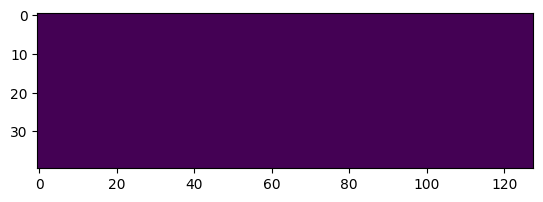

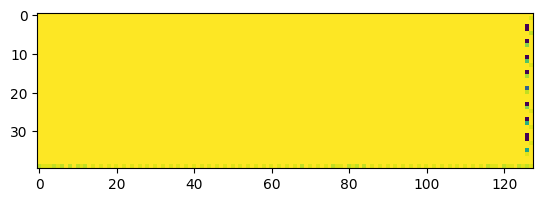

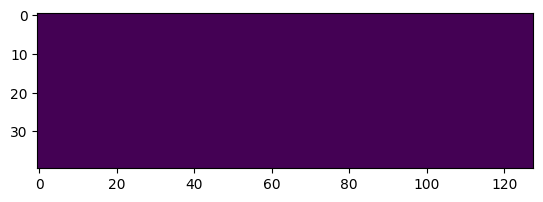

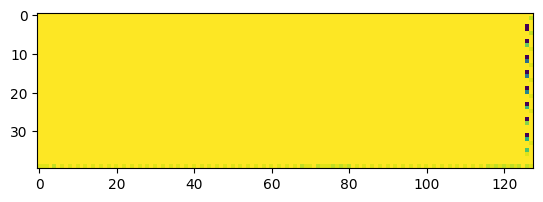

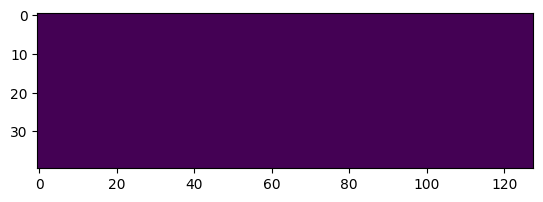

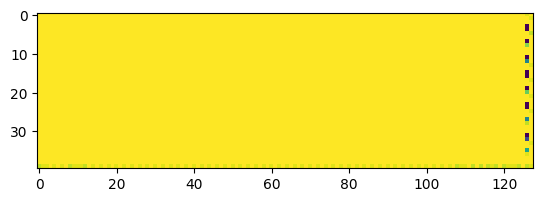

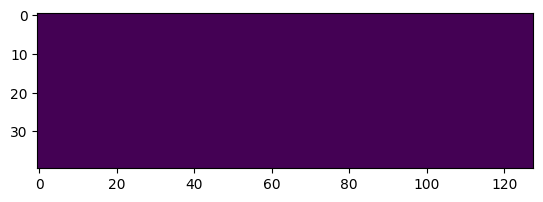

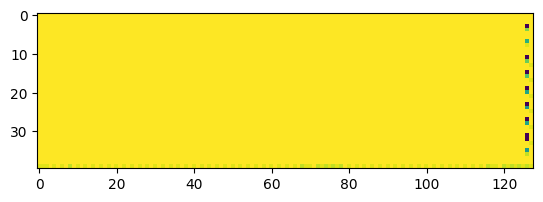

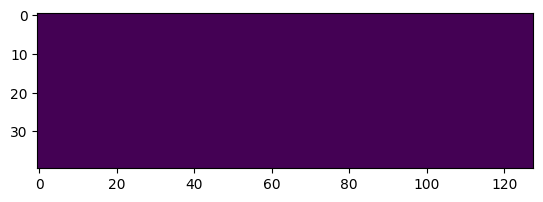

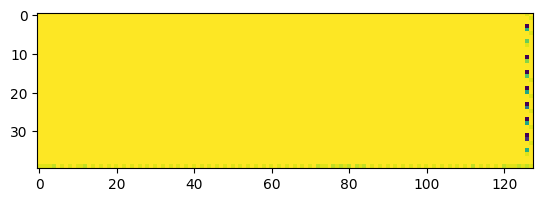

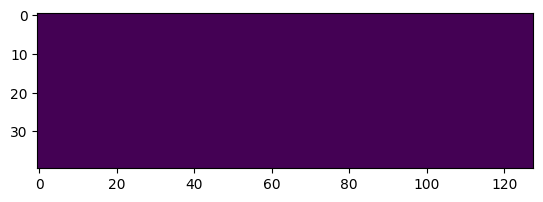

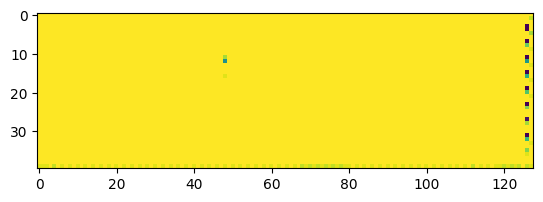

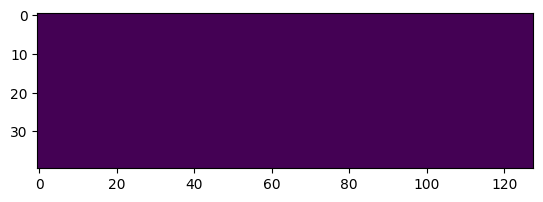

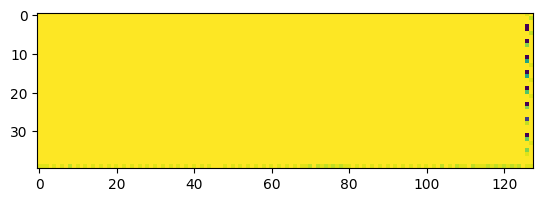

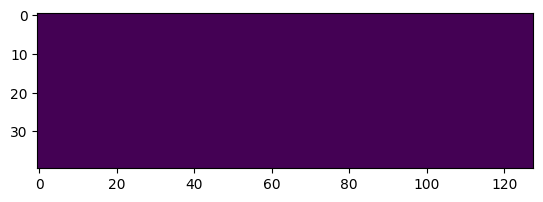

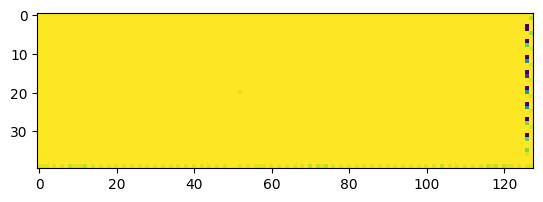

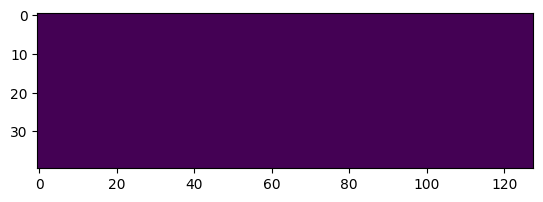

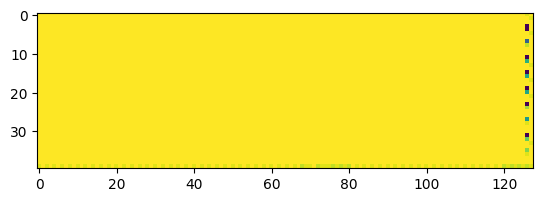

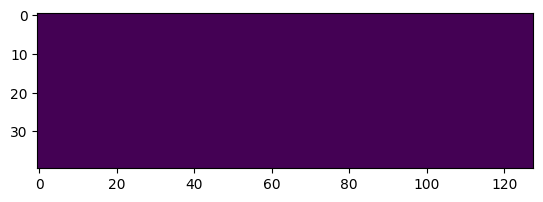

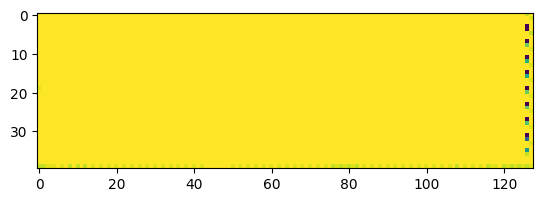

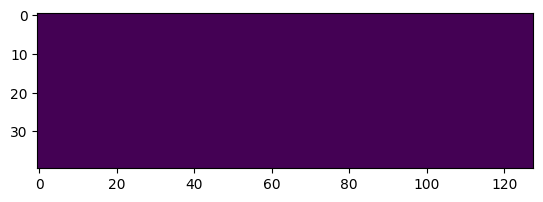

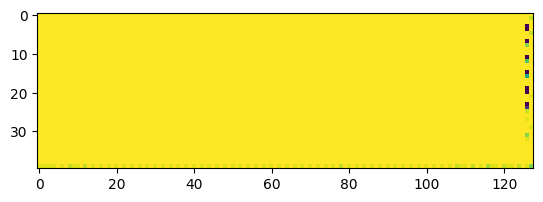

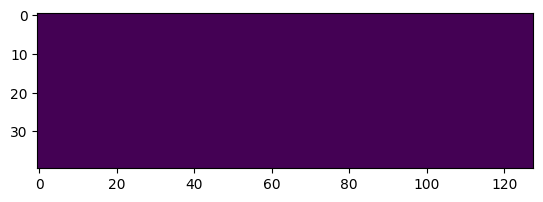

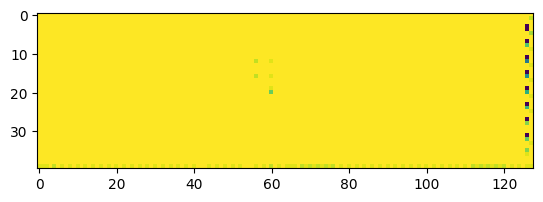

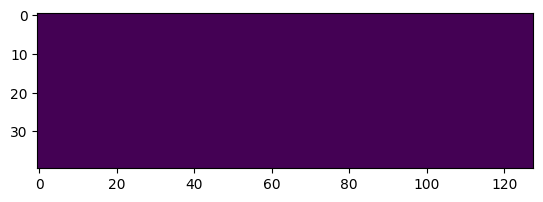

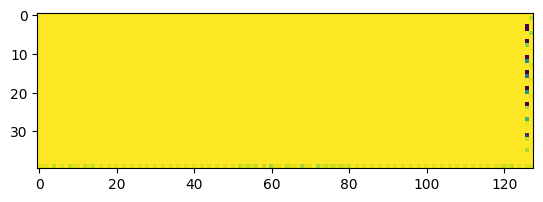

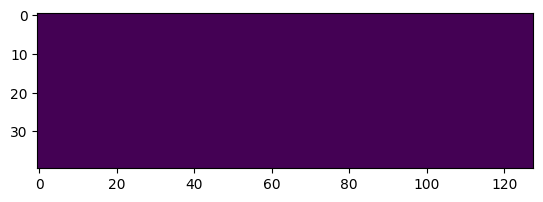

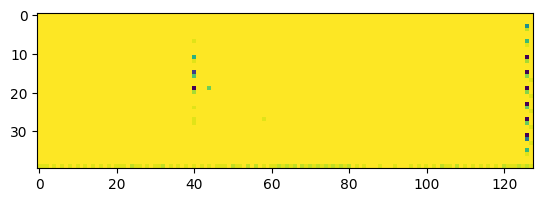

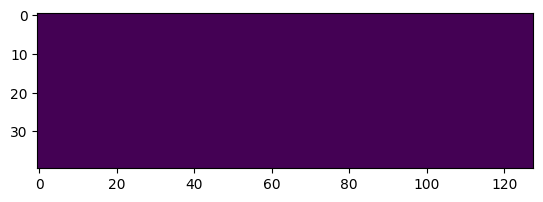

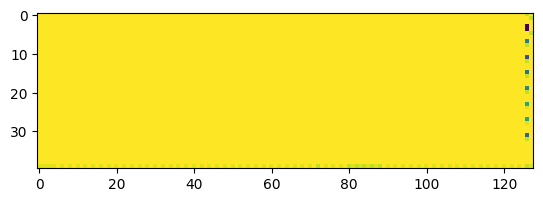

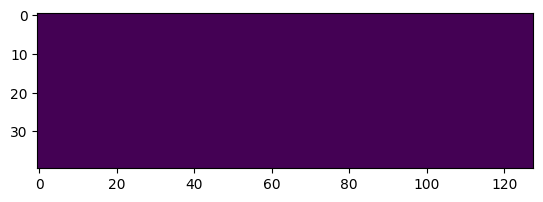

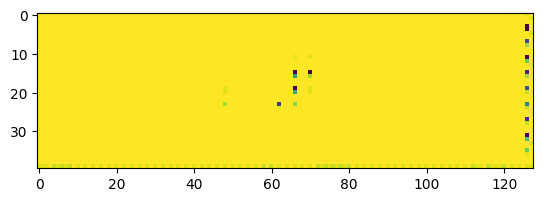

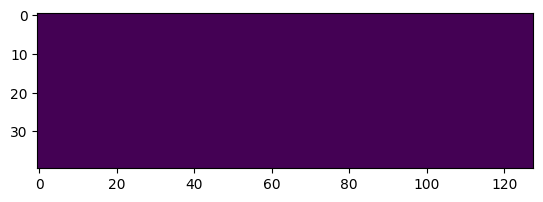

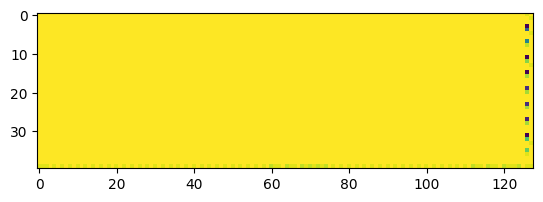

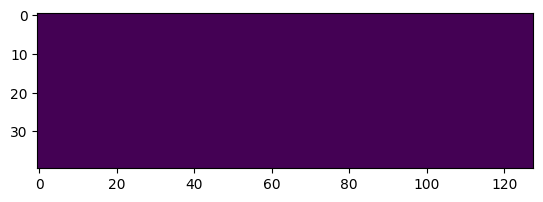

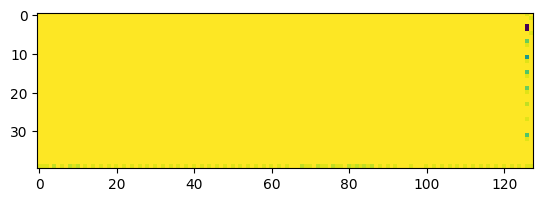

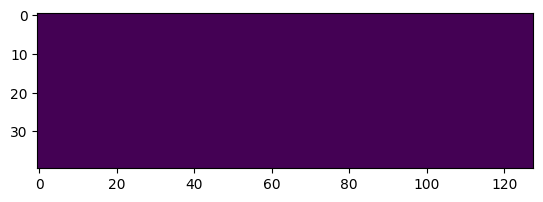

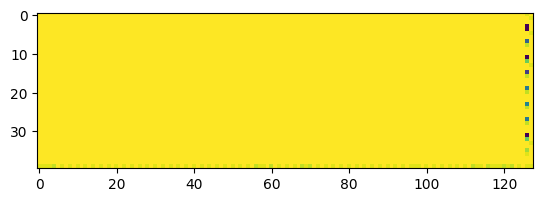

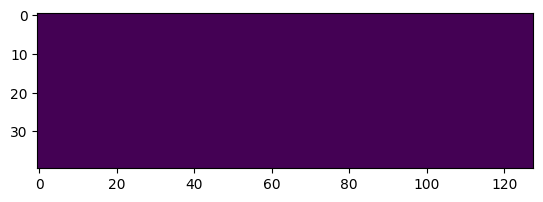

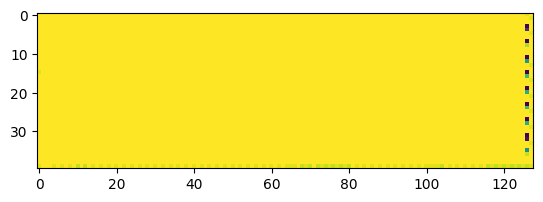

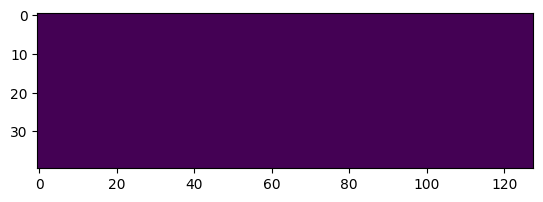

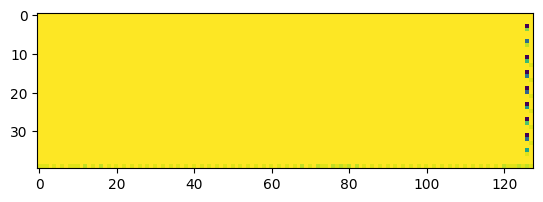

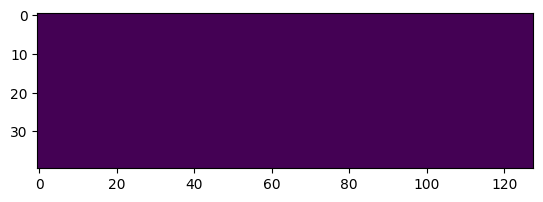

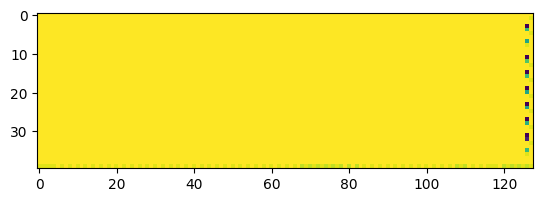

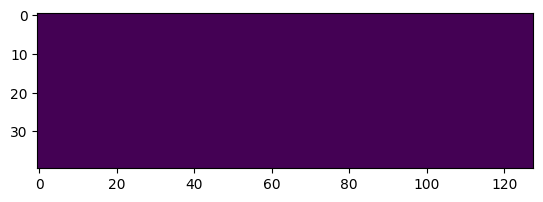

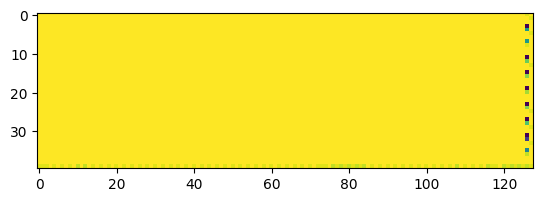

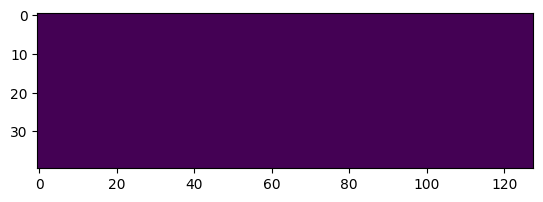

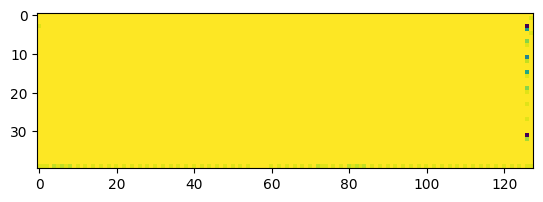

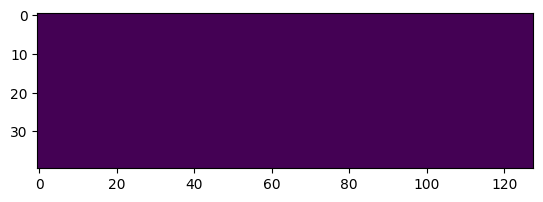

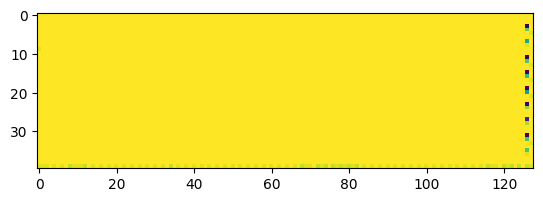

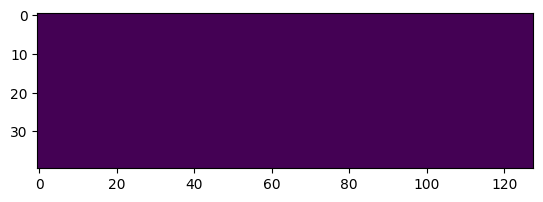

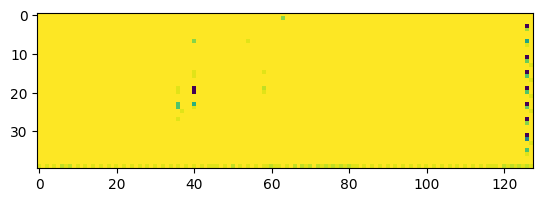

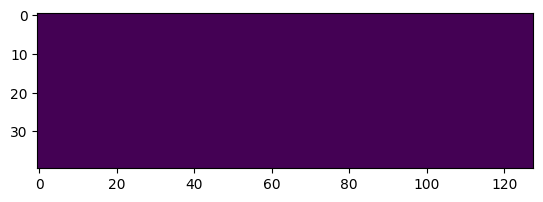

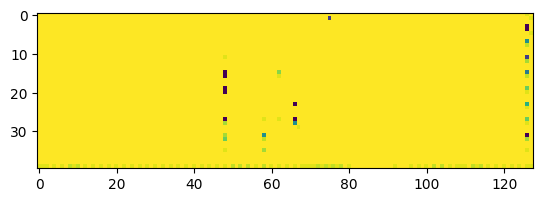

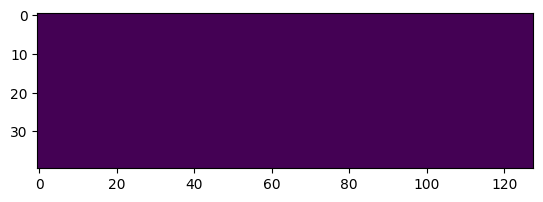

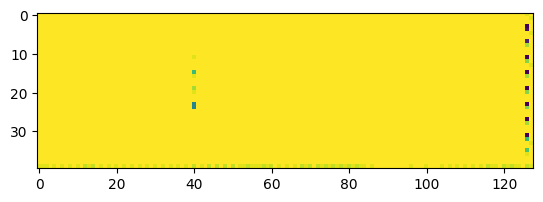

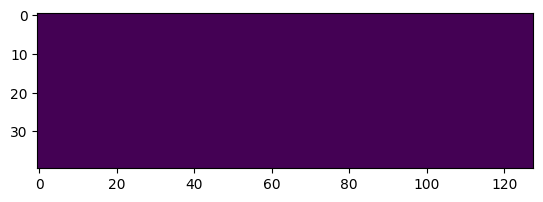

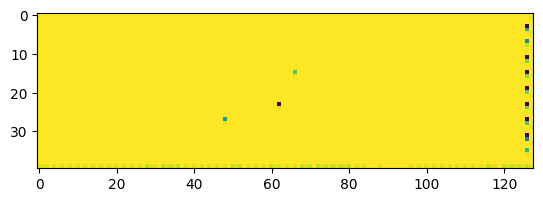

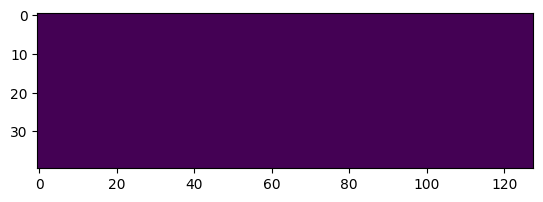

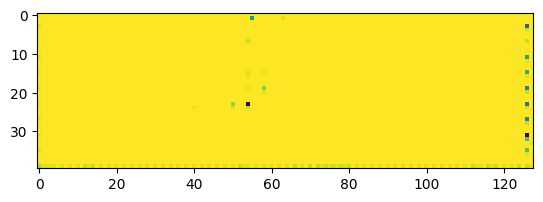

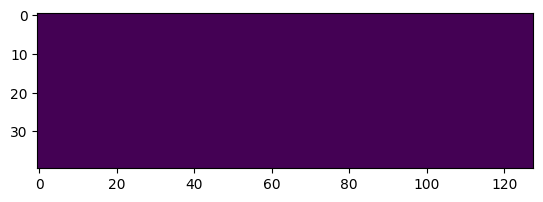

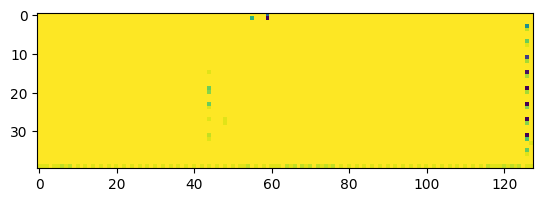

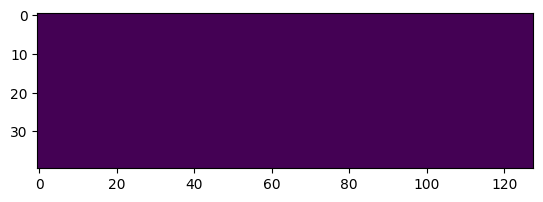

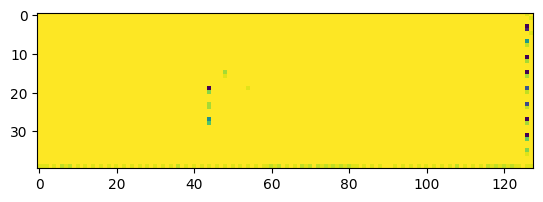

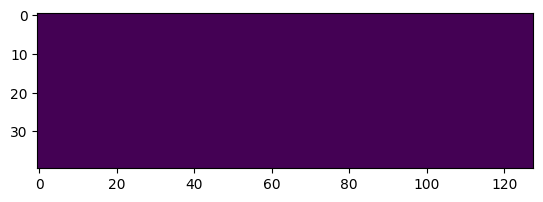

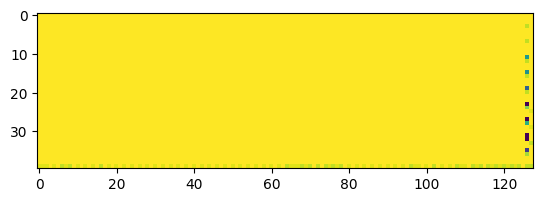

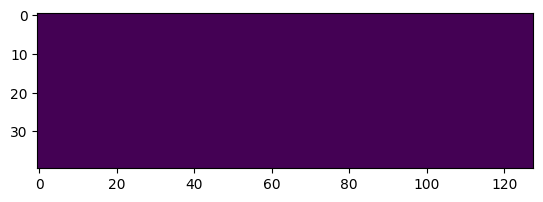

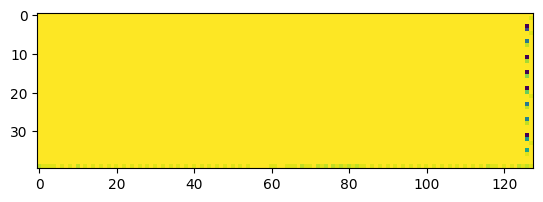

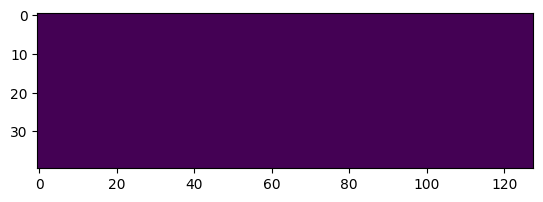

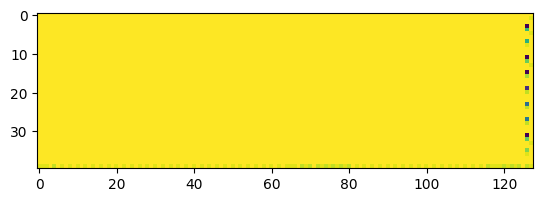

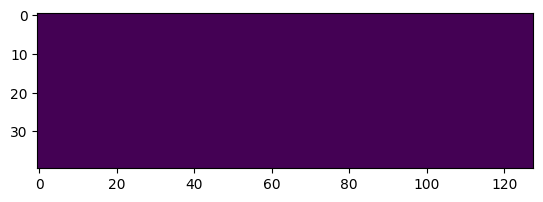

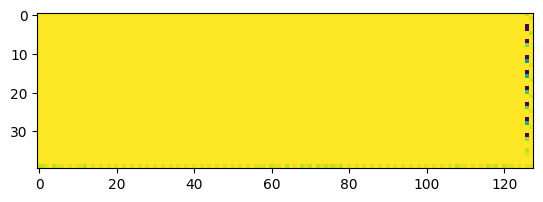

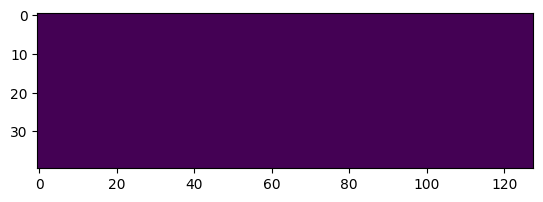

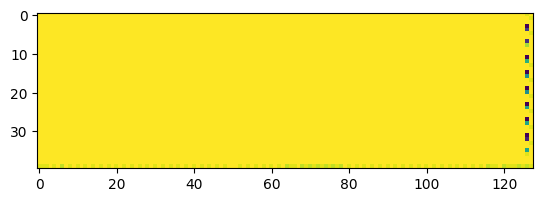

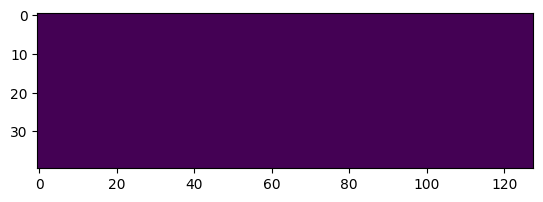

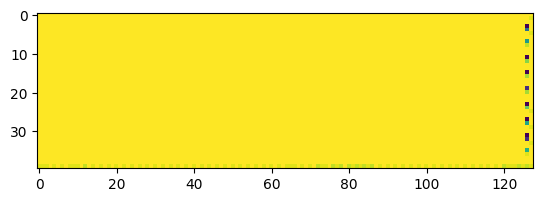

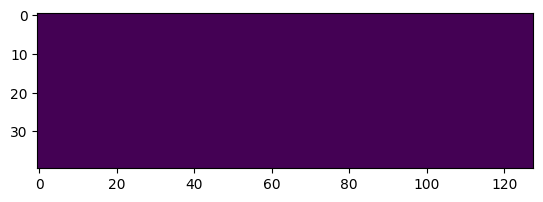

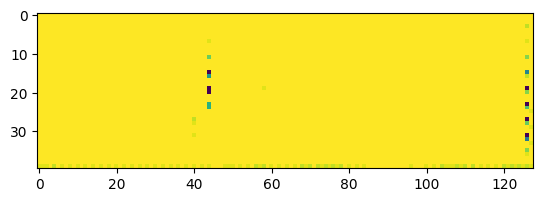

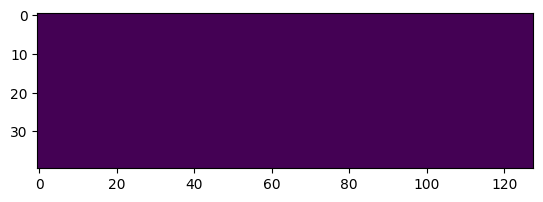

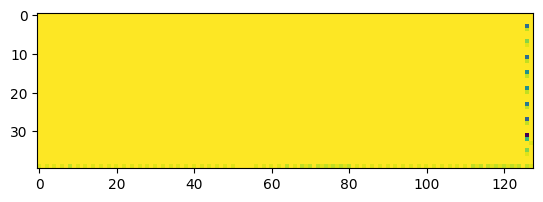

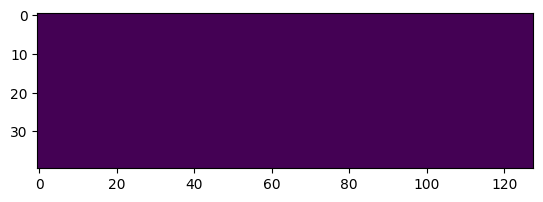

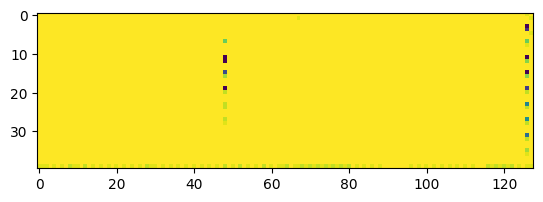

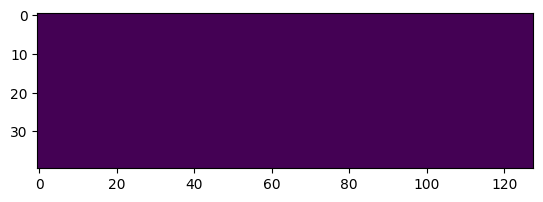

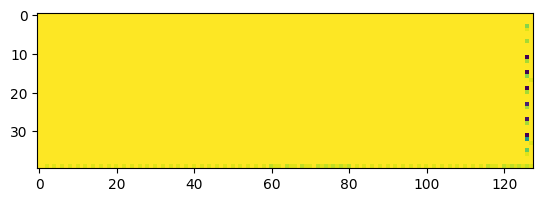

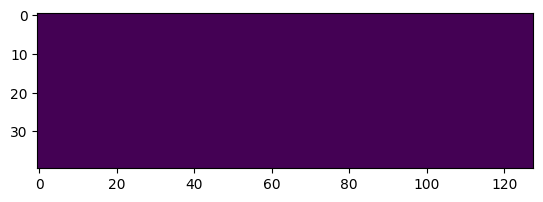

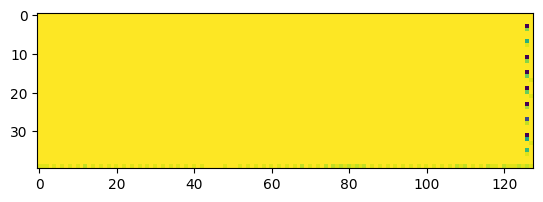

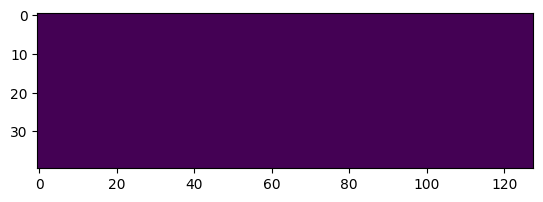

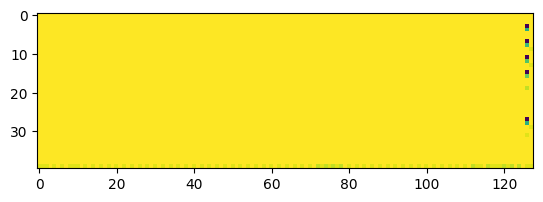

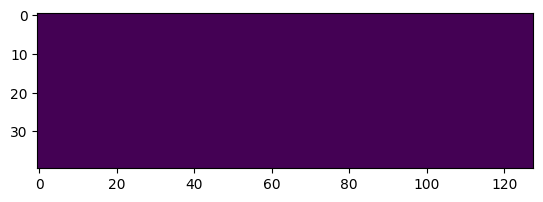

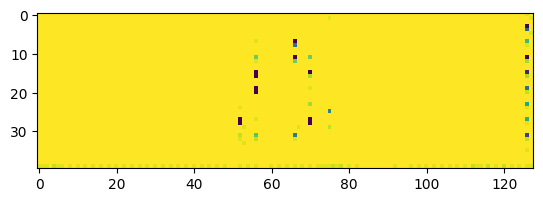

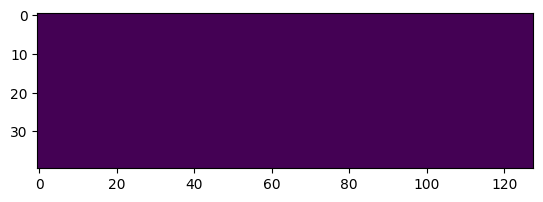

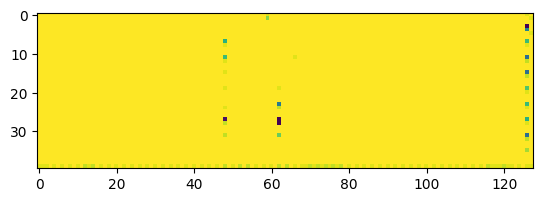

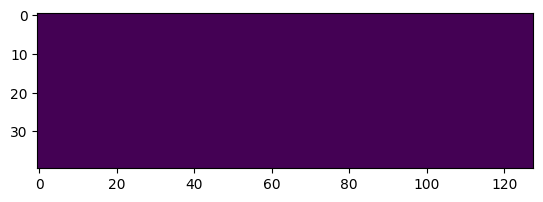

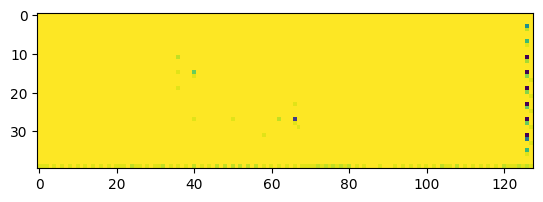

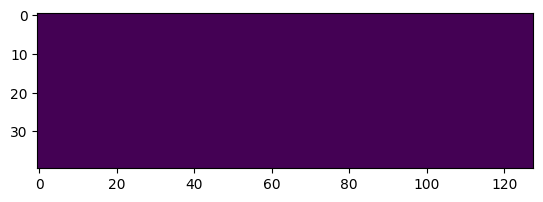

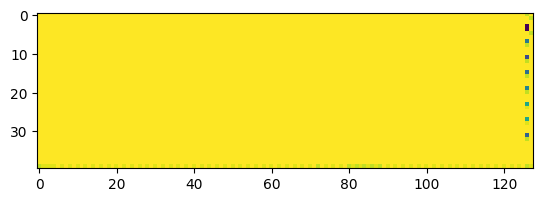

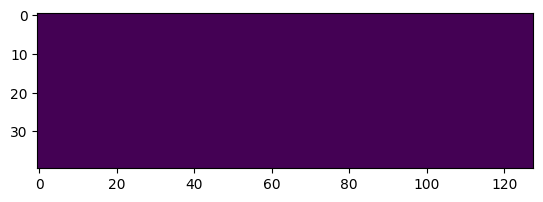

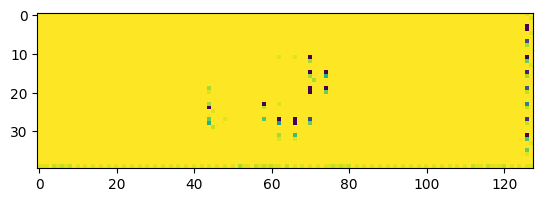

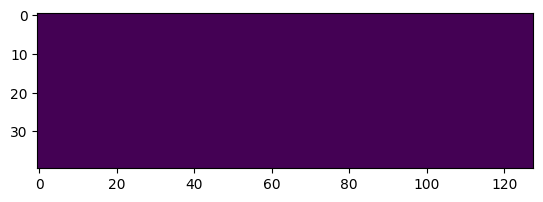

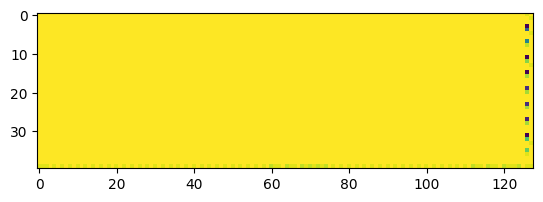

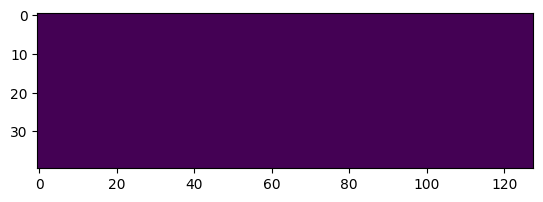

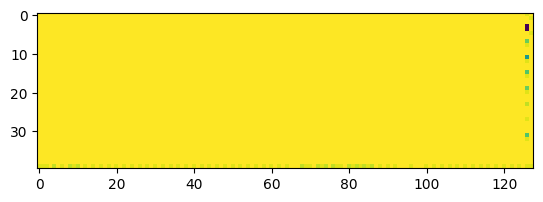

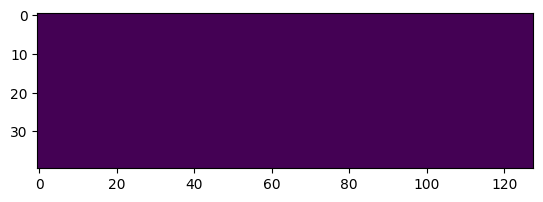

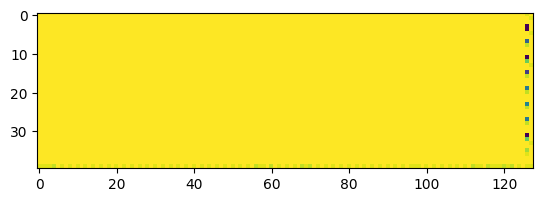

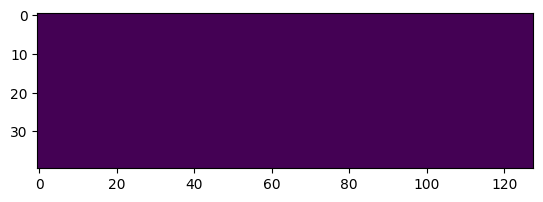

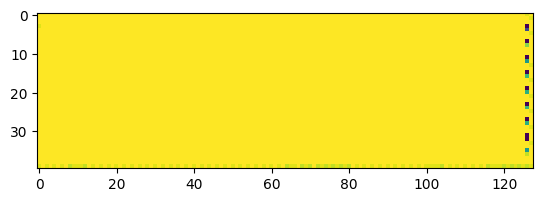

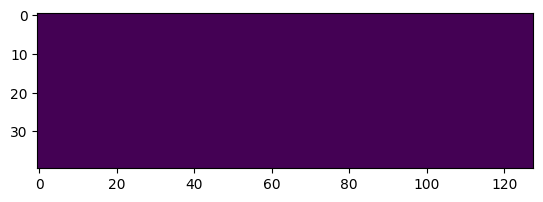

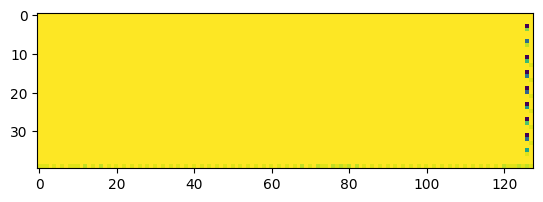

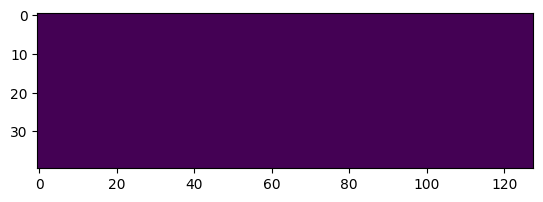

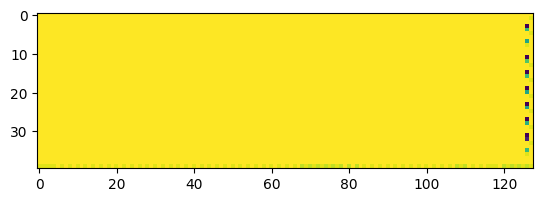

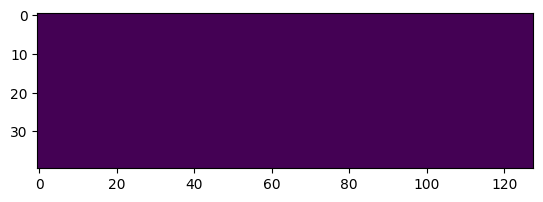

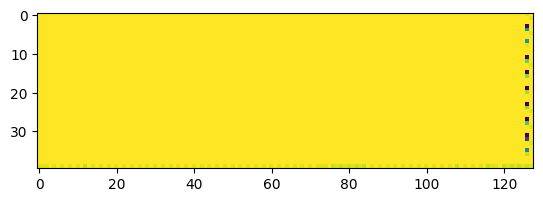

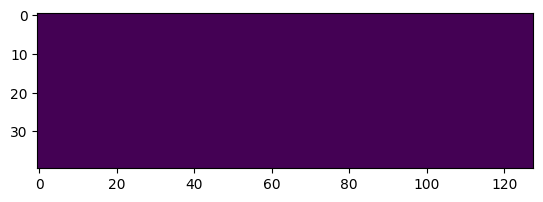

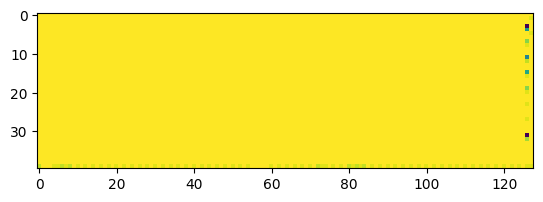

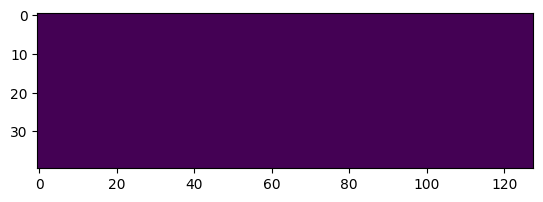

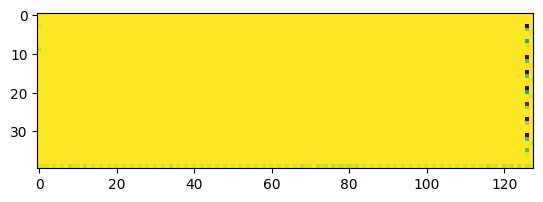

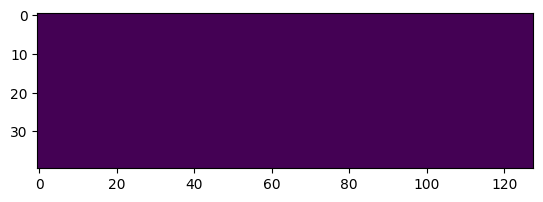

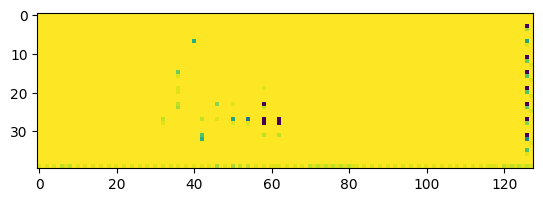

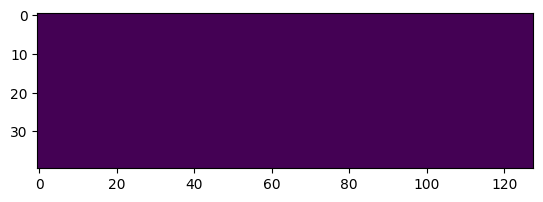

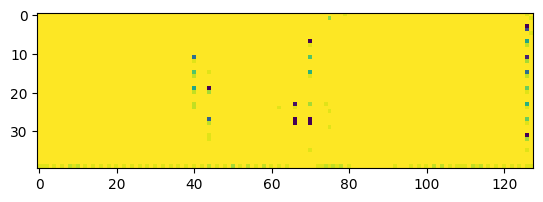

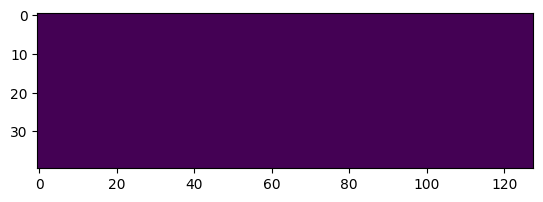

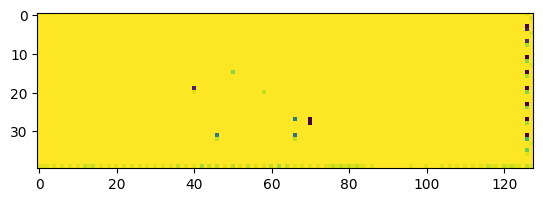

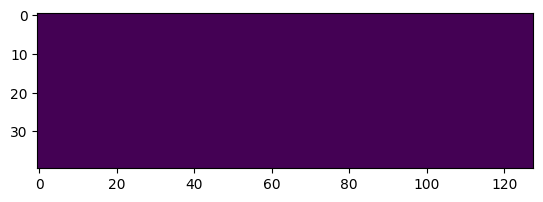

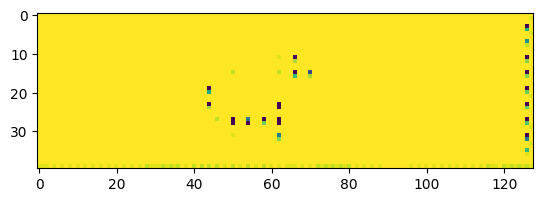

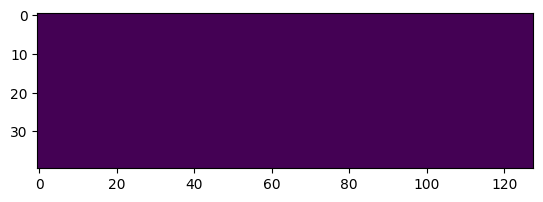

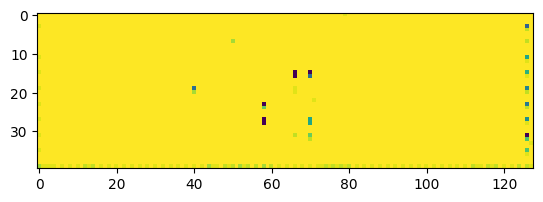

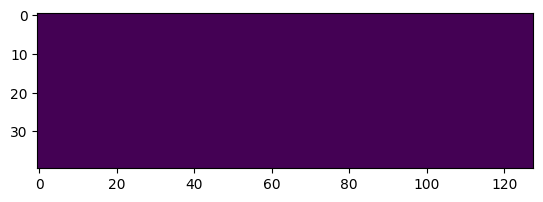

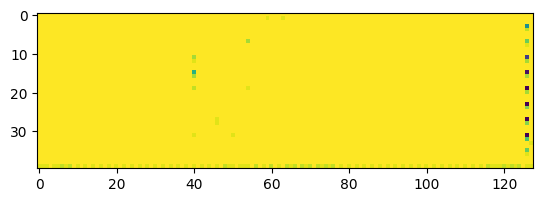

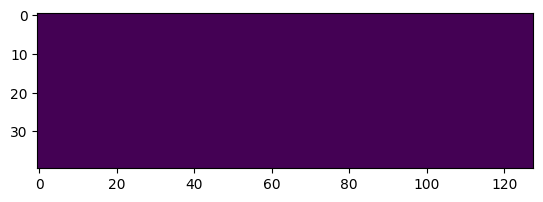

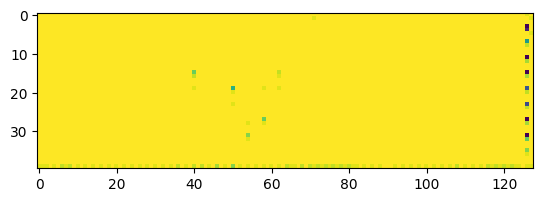

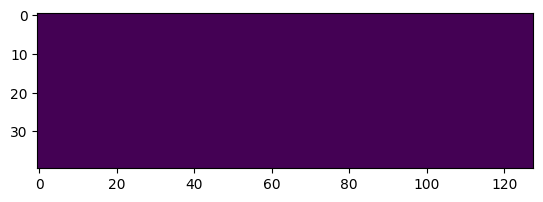

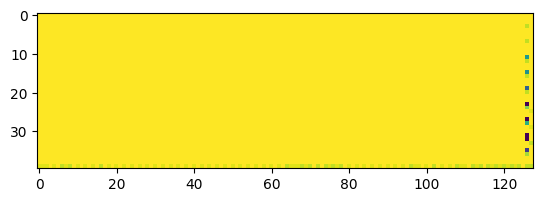

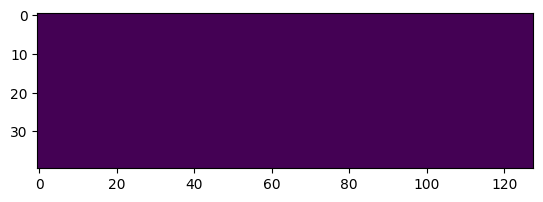

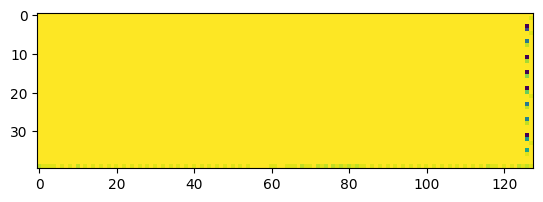

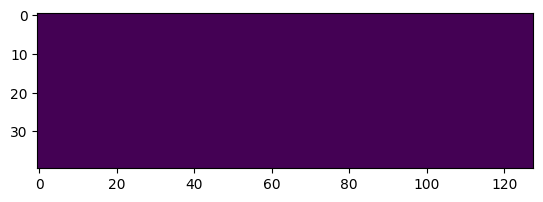

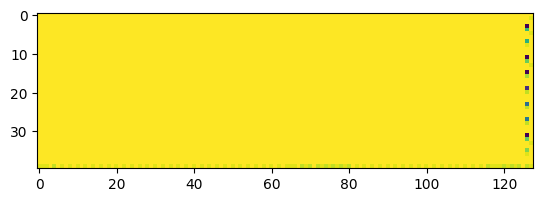

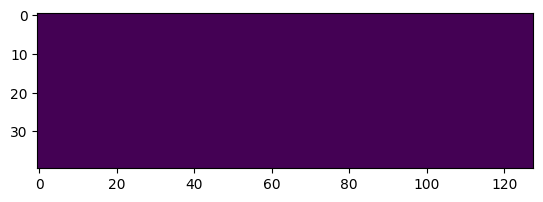

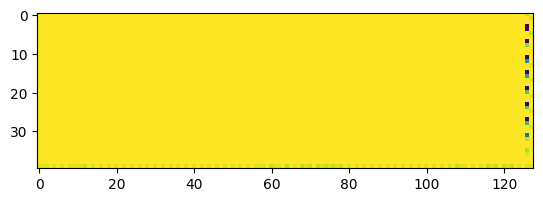

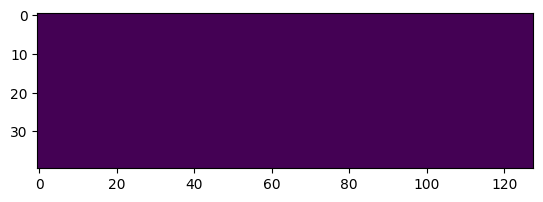

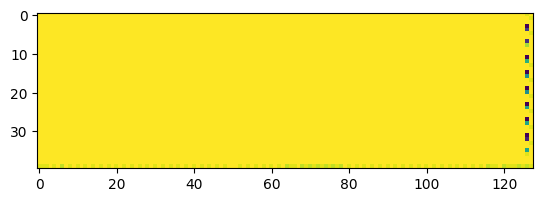

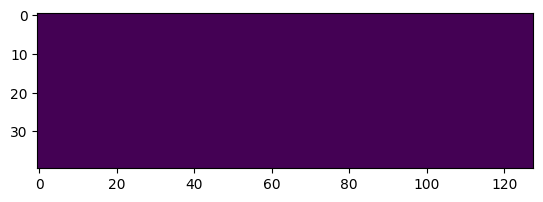

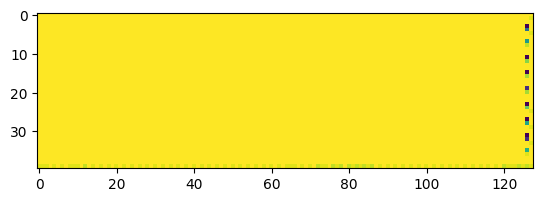

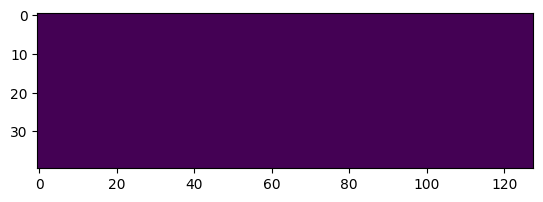

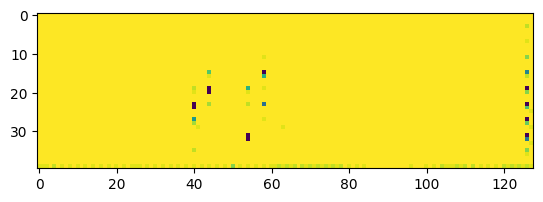

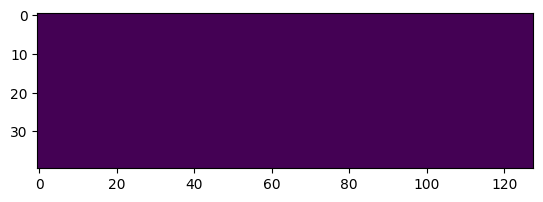

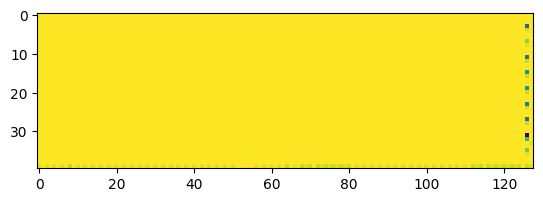

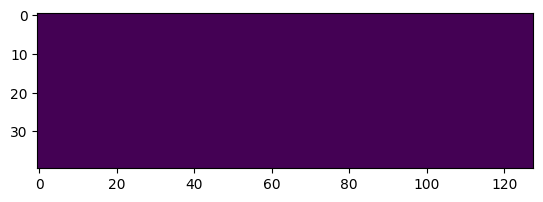

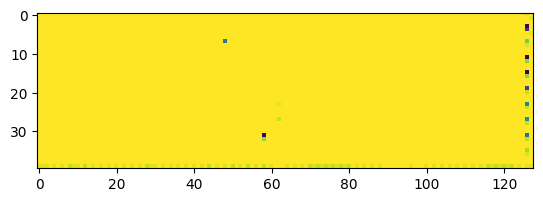

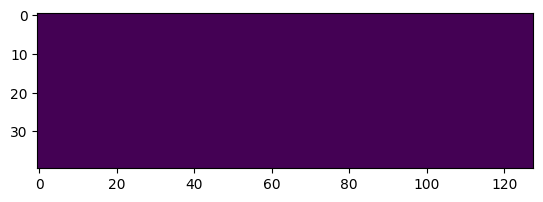

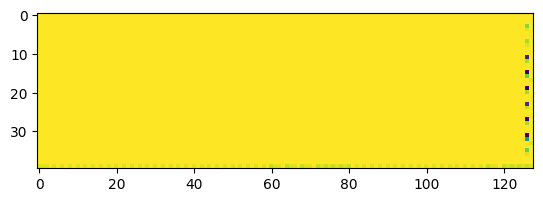

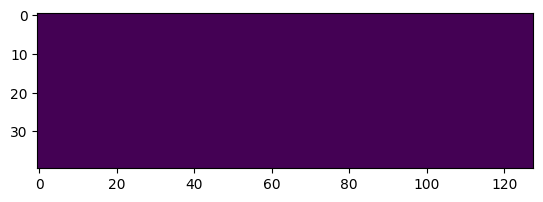

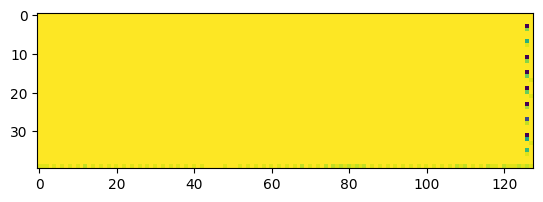

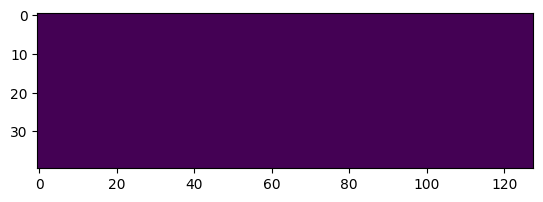

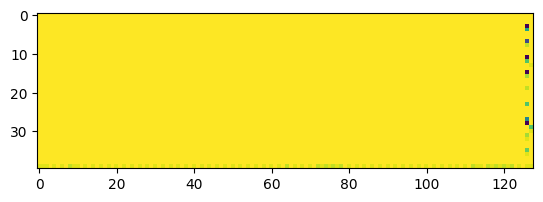

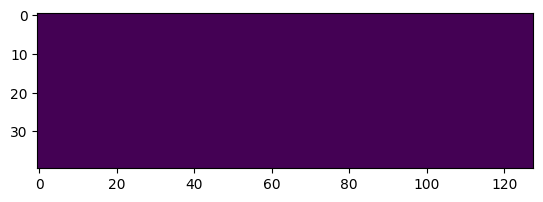

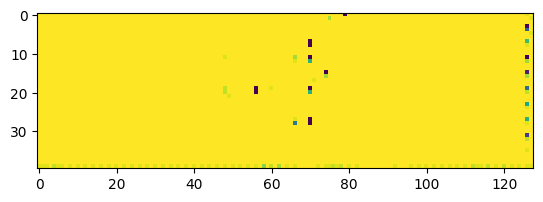

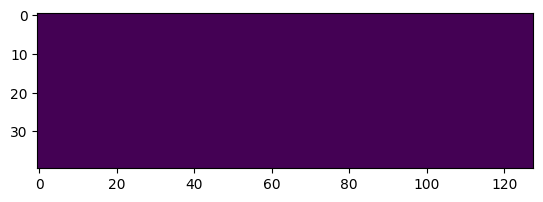

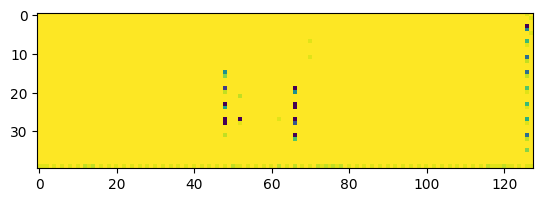

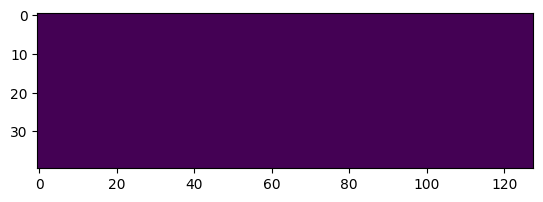

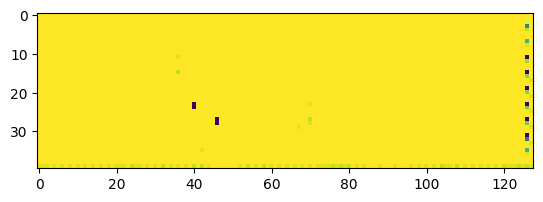

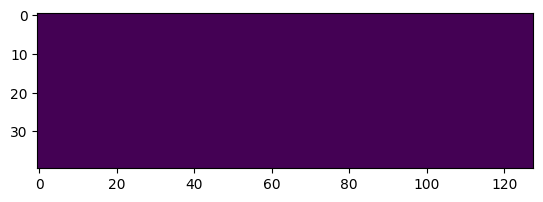

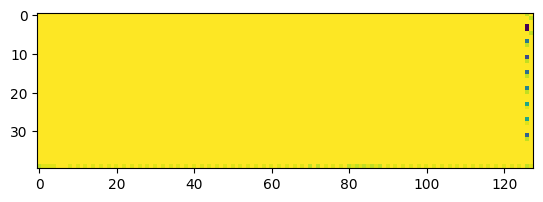

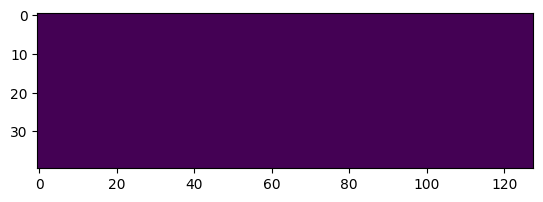

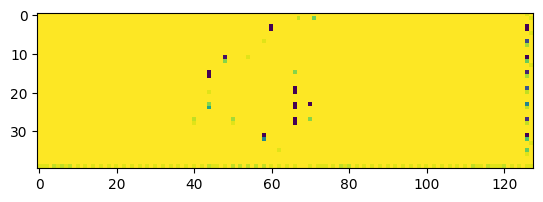

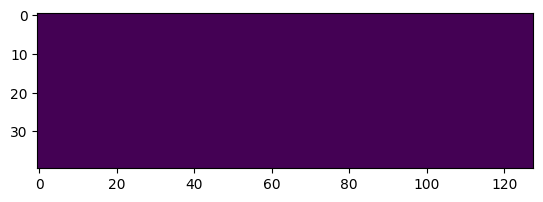

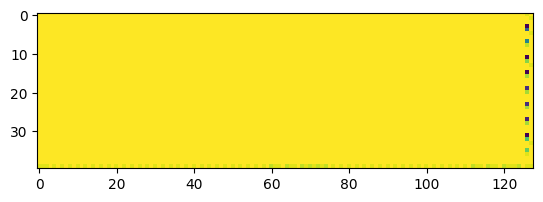

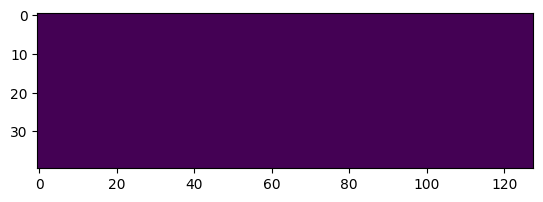

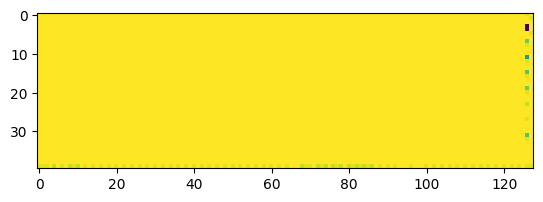

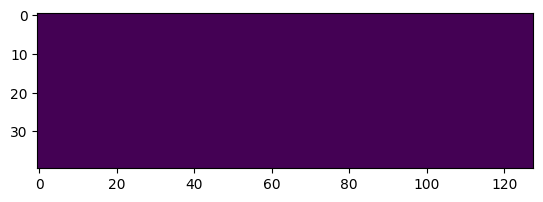

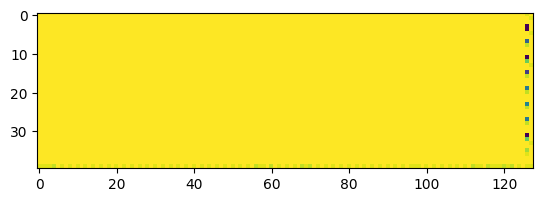

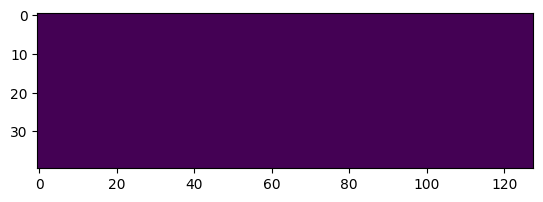

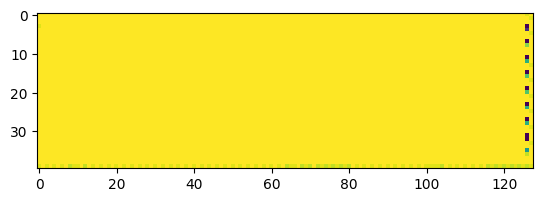

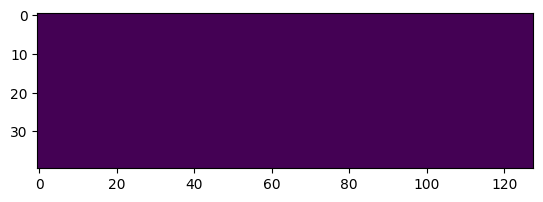

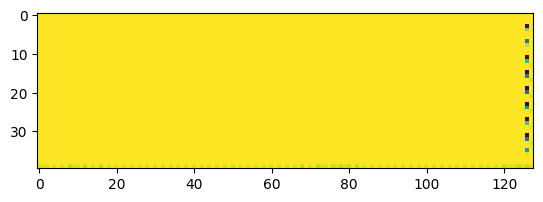

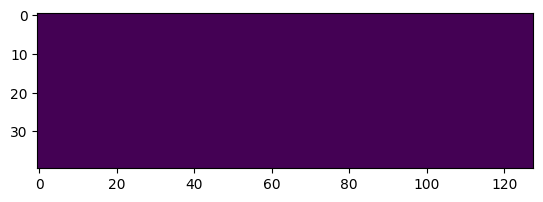

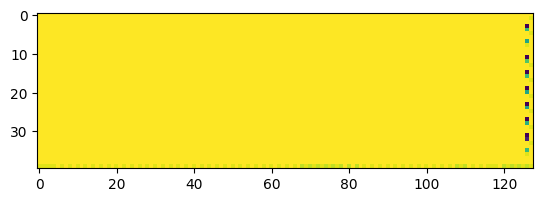

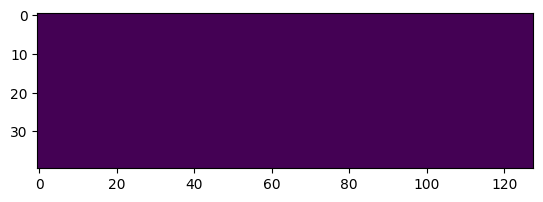

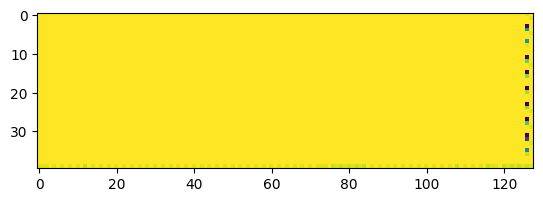

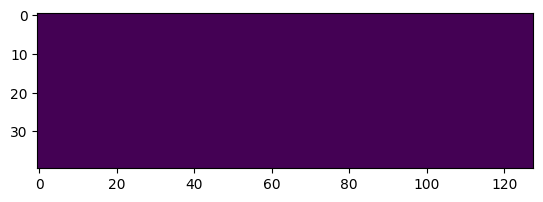

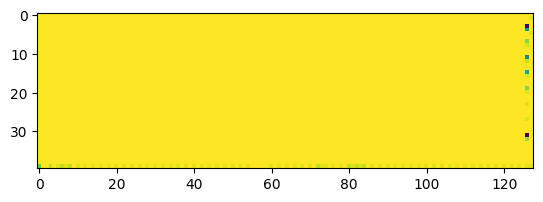

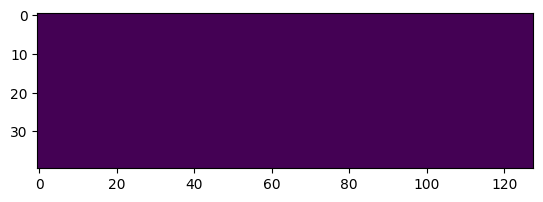

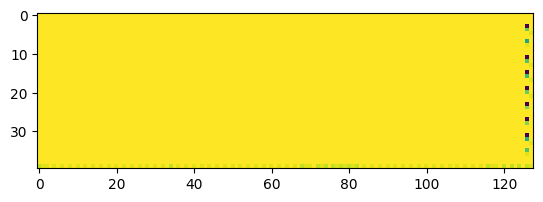

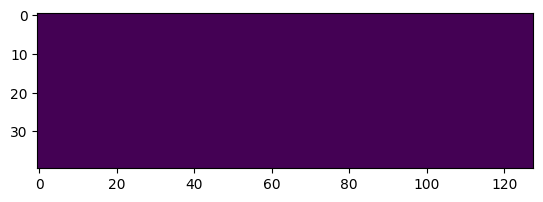

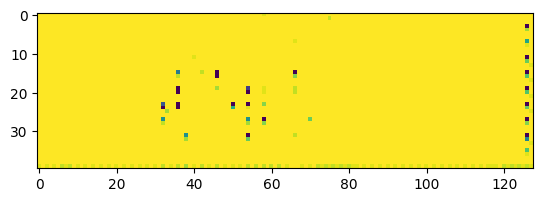

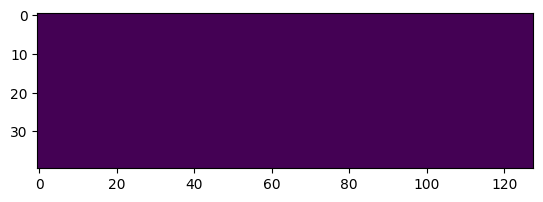

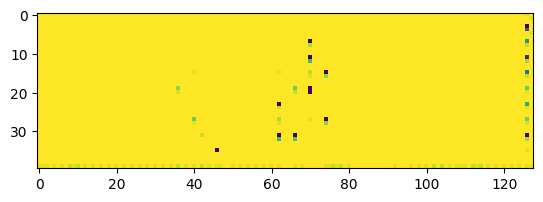

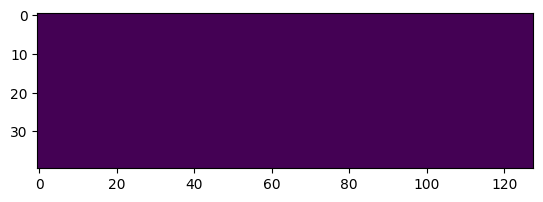

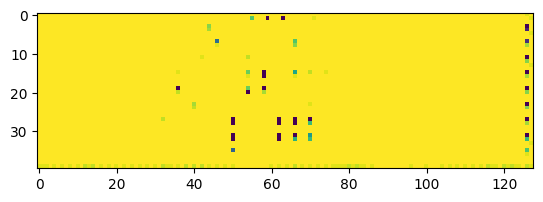

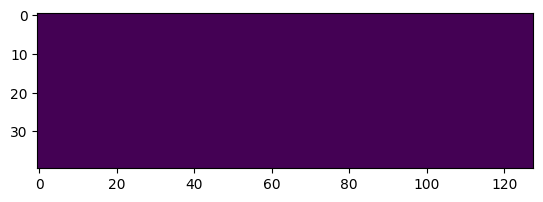

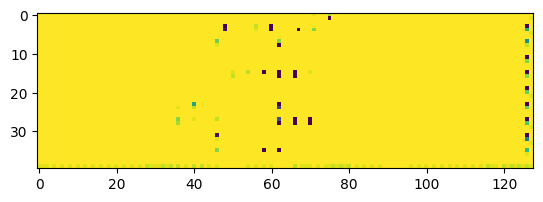

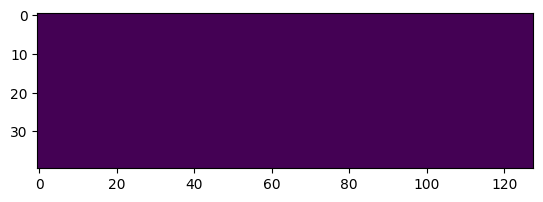

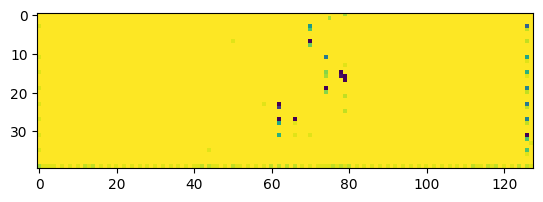

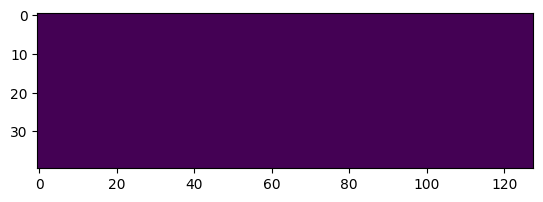

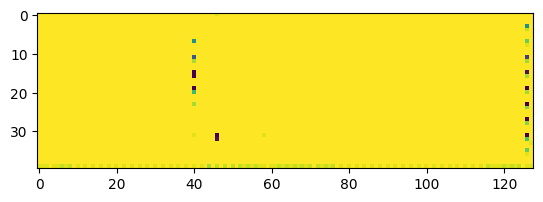

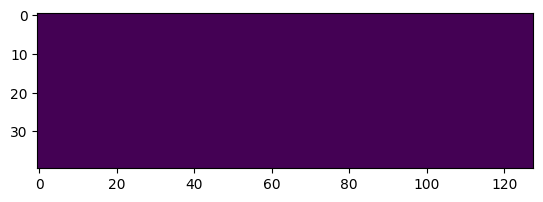

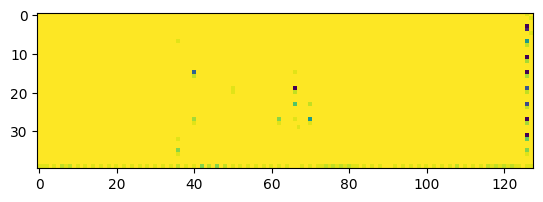

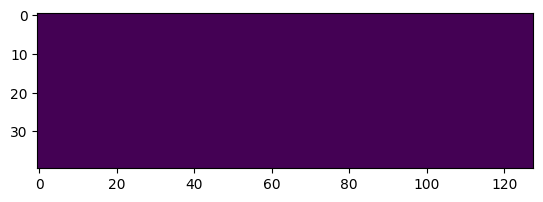

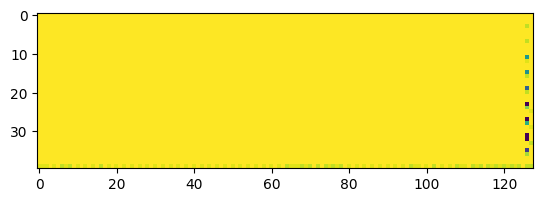

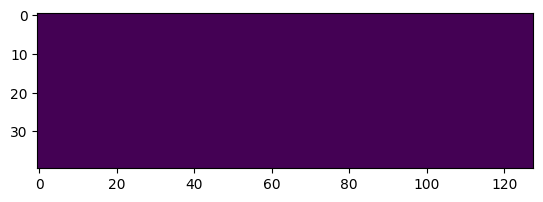

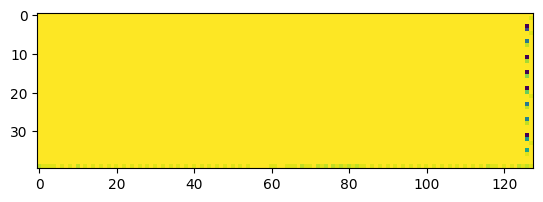

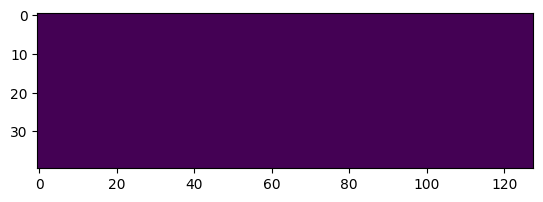

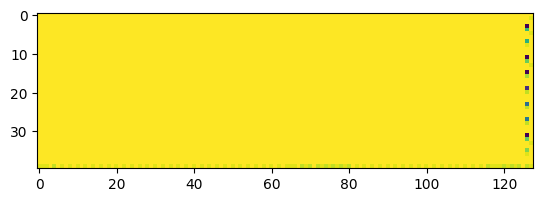

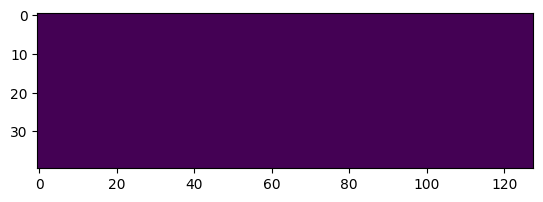

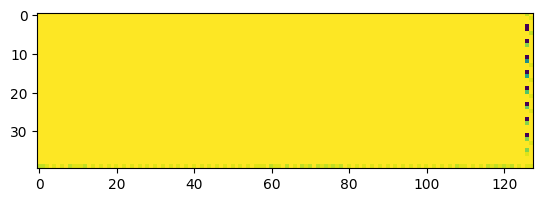

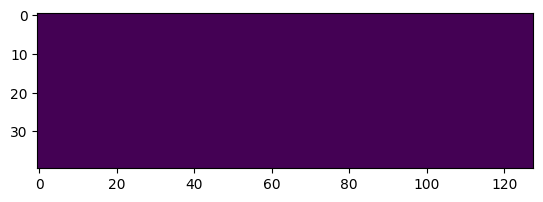

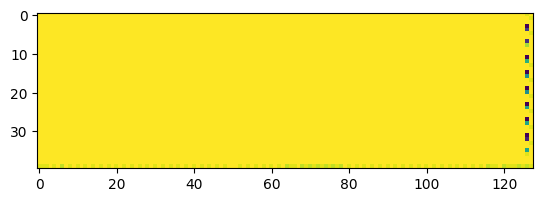

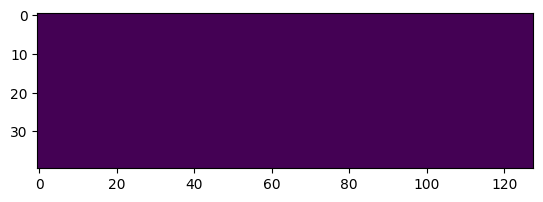

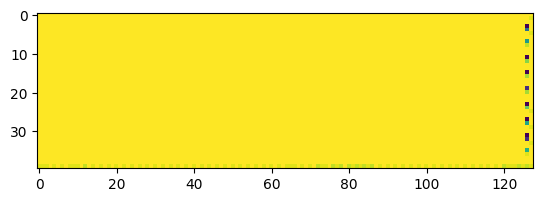

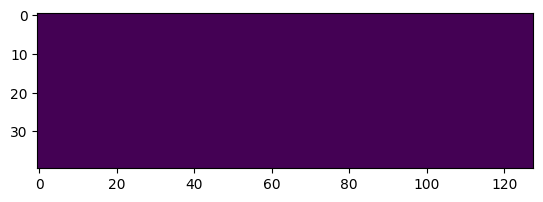

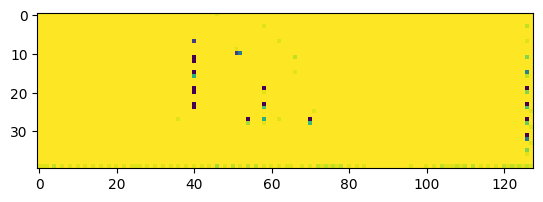

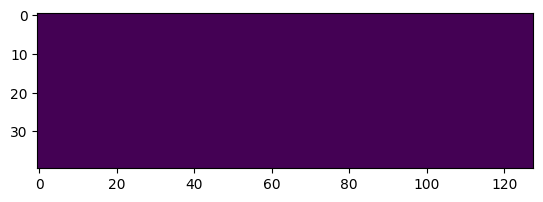

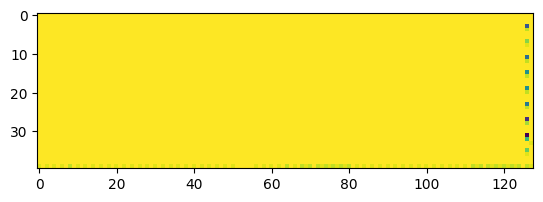

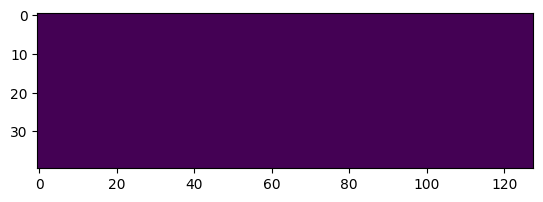

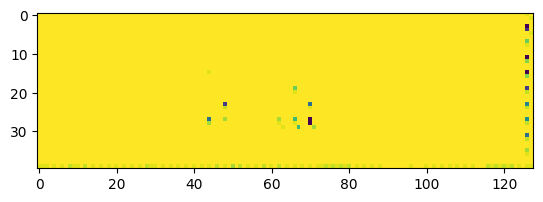

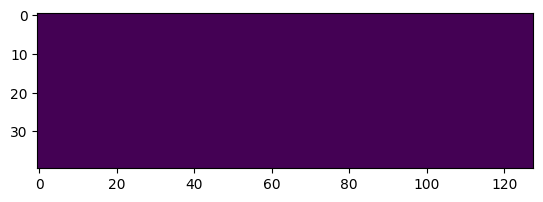

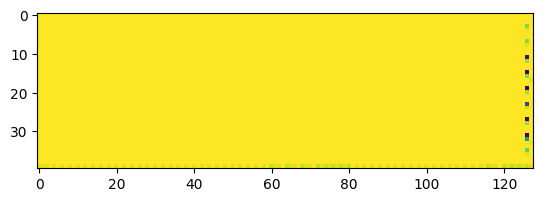

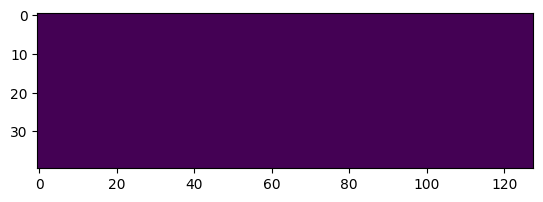

In [48]:
for i in range(128):
    plt.imshow(net(torch.unsqueeze(test_dataset[i][0],0).to(device)).cpu().detach().numpy()[0][0])
    plt.show()
    plt.imshow(test_dataset[i][1][0])
    plt.show()

now for 2.5D SUNet COR

In [270]:
X = centring(guys_X,3) 
Y = to_one_hot(guys_Y)
#Y = to_one_hot_single(guys_Y,1)

In [271]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y,test_size = 0.1)

In [272]:
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size = 0.1)

In [273]:
train_dataset = numpy_dataset_frac(X_train, Y_train,3,"sandwich")
val_dataset = numpy_dataset_frac(X_val, Y_val,3,"sandwich")

In [274]:
train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True, drop_last=True)
val_dataloader = DataLoader(val_dataset, batch_size=16, shuffle=False, drop_last=True)

In [275]:
test_dataset = numpy_dataset_frac(X_test, Y_test,3,"sandwich")
test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=False, drop_last=True)

In [276]:
Y_train.shape

(256, 2, 40, 128, 128)

In [277]:
#train_dataset[500][0].shape

In [278]:
net = UNet(in_channels=3, init_features=4, out_channels=2).to(device)
print('Trainable params: ', net.parameters())

Trainable params:  <generator object Module.parameters at 0x00000243042DD930>


Train Epoch: 1 [16/32768 (0%)]	Loss: 0.515481
Train Epoch: 1 [1616/32768 (5%)]	Loss: 0.201043
Train Epoch: 1 [3216/32768 (10%)]	Loss: 0.170266
Train Epoch: 1 [4816/32768 (15%)]	Loss: 0.177357
Train Epoch: 1 [6416/32768 (20%)]	Loss: 0.162096
Train Epoch: 1 [8016/32768 (24%)]	Loss: 0.164236
Train Epoch: 1 [9616/32768 (29%)]	Loss: 0.224070
Train Epoch: 1 [11216/32768 (34%)]	Loss: 0.154332
Train Epoch: 1 [12816/32768 (39%)]	Loss: 0.172620
Train Epoch: 1 [14416/32768 (44%)]	Loss: 0.175472
Train Epoch: 1 [16016/32768 (49%)]	Loss: 0.186499
Train Epoch: 1 [17616/32768 (54%)]	Loss: 0.177105
Train Epoch: 1 [19216/32768 (59%)]	Loss: 0.143421
Train Epoch: 1 [20816/32768 (64%)]	Loss: 0.184902
Train Epoch: 1 [22416/32768 (68%)]	Loss: 0.194036
Train Epoch: 1 [24016/32768 (73%)]	Loss: 0.146429
Train Epoch: 1 [25616/32768 (78%)]	Loss: 0.161093
Train Epoch: 1 [27216/32768 (83%)]	Loss: 0.169611
Train Epoch: 1 [28816/32768 (88%)]	Loss: 0.180632
Train Epoch: 1 [30416/32768 (93%)]	Loss: 0.198737
Train Epoch

Train Epoch: 8 [3216/32768 (10%)]	Loss: 0.174503
Train Epoch: 8 [4816/32768 (15%)]	Loss: 0.209110
Train Epoch: 8 [6416/32768 (20%)]	Loss: 0.175924
Train Epoch: 8 [8016/32768 (24%)]	Loss: 0.137930
Train Epoch: 8 [9616/32768 (29%)]	Loss: 0.142819
Train Epoch: 8 [11216/32768 (34%)]	Loss: 0.150237
Train Epoch: 8 [12816/32768 (39%)]	Loss: 0.159741
Train Epoch: 8 [14416/32768 (44%)]	Loss: 0.157994
Train Epoch: 8 [16016/32768 (49%)]	Loss: 0.175038
Train Epoch: 8 [17616/32768 (54%)]	Loss: 0.106504
Train Epoch: 8 [19216/32768 (59%)]	Loss: 0.191852
Train Epoch: 8 [20816/32768 (64%)]	Loss: 0.140192
Train Epoch: 8 [22416/32768 (68%)]	Loss: 0.150200
Train Epoch: 8 [24016/32768 (73%)]	Loss: 0.146160
Train Epoch: 8 [25616/32768 (78%)]	Loss: 0.139406
Train Epoch: 8 [27216/32768 (83%)]	Loss: 0.167314
Train Epoch: 8 [28816/32768 (88%)]	Loss: 0.195034
Train Epoch: 8 [30416/32768 (93%)]	Loss: 0.157418
Train Epoch: 8 [32016/32768 (98%)]	Loss: 0.198463

Training set: Average loss: 0.1656
Time taken for epoc

Train Epoch: 15 [3216/32768 (10%)]	Loss: 0.151662
Train Epoch: 15 [4816/32768 (15%)]	Loss: 0.191581
Train Epoch: 15 [6416/32768 (20%)]	Loss: 0.144599
Train Epoch: 15 [8016/32768 (24%)]	Loss: 0.142649
Train Epoch: 15 [9616/32768 (29%)]	Loss: 0.149207
Train Epoch: 15 [11216/32768 (34%)]	Loss: 0.134957
Train Epoch: 15 [12816/32768 (39%)]	Loss: 0.143126
Train Epoch: 15 [14416/32768 (44%)]	Loss: 0.186792
Train Epoch: 15 [16016/32768 (49%)]	Loss: 0.155535
Train Epoch: 15 [17616/32768 (54%)]	Loss: 0.175844
Train Epoch: 15 [19216/32768 (59%)]	Loss: 0.189907
Train Epoch: 15 [20816/32768 (64%)]	Loss: 0.135276
Train Epoch: 15 [22416/32768 (68%)]	Loss: 0.150275
Train Epoch: 15 [24016/32768 (73%)]	Loss: 0.191197
Train Epoch: 15 [25616/32768 (78%)]	Loss: 0.190039
Train Epoch: 15 [27216/32768 (83%)]	Loss: 0.182710
Train Epoch: 15 [28816/32768 (88%)]	Loss: 0.132232
Train Epoch: 15 [30416/32768 (93%)]	Loss: 0.169061
Train Epoch: 15 [32016/32768 (98%)]	Loss: 0.139614

Training set: Average loss: 0.1606


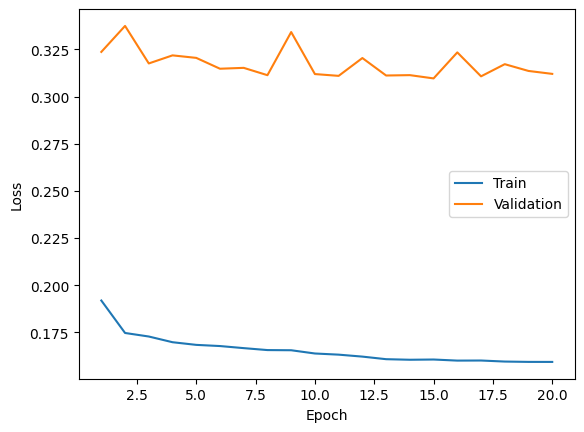

In [279]:
class_loss = dice_loss()
optim = torch.optim.Adam(net.parameters(), lr = 0.01)

losses = []
max_epochs = 20
for epoch in range(1, max_epochs+1):
    train_loss = train(net, train_dataloader, optim, class_loss, epoch)
    val_loss = val(net, val_dataloader, optim, class_loss, epoch)
    losses.append([train_loss, val_loss])

losses = np.array(losses).T
print(losses.shape)
its = np.linspace(1, max_epochs, max_epochs)

plt.figure()
plt.plot(its, losses[0,:])
plt.plot(its, losses[1,:])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'])

In [280]:
pred, true, test_loss, test_acc = predict(net, test_dataloader)

Test set: Average loss: 0.3118
Test set: Average Acc: 0.8554




and RUNet SAG

In [281]:
X = centring(guys_X,1) 
Y = to_one_hot(guys_Y)
#Y = to_one_hot_single(guys_Y,1)

In [282]:
X.shape

(317, 1, 40, 128, 128)

In [283]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y,test_size = 0.1)

In [284]:
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size = 0.1)

In [285]:
train_dataset = integer_numpy_dataset(X_train, Y_train) #as RUNet takes 3D tensors as input
val_dataset = integer_numpy_dataset(X_val, Y_val)

In [286]:
train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True, drop_last=True)
val_dataloader = DataLoader(val_dataset, batch_size=16, shuffle=False, drop_last=True)

In [287]:
test_dataset = integer_numpy_dataset(X_test, Y_test)
test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=False, drop_last=True)

In [288]:
Y_train.shape

(256, 2, 40, 128, 128)

In [289]:
train_dataset[4][0].shape

torch.Size([1, 40, 128, 128])

In [290]:
net = RUNet(in_channels=1, init_features=4, out_channels=2, token_shape = (128,128)).to(device)
print('Trainable params: ', net.parameters())

Trainable params:  <generator object Module.parameters at 0x00000243042DE1F0>


Train Epoch: 1 [16/256 (6%)]	Loss: 0.513138

Training set: Average loss: 0.3844
Time taken for epoch =  8.573073148727417
Validation set: Average loss: 0.3041


Train Epoch: 2 [16/256 (6%)]	Loss: 0.281171

Training set: Average loss: 0.2125
Time taken for epoch =  7.584029912948608
Validation set: Average loss: 0.1455


Train Epoch: 3 [16/256 (6%)]	Loss: 0.145439

Training set: Average loss: 0.1035
Time taken for epoch =  7.461549997329712
Validation set: Average loss: 0.0735


Train Epoch: 4 [16/256 (6%)]	Loss: 0.067470

Training set: Average loss: 0.0541
Time taken for epoch =  7.483980894088745
Validation set: Average loss: 0.0479


Train Epoch: 5 [16/256 (6%)]	Loss: 0.043581

Training set: Average loss: 0.0380
Time taken for epoch =  7.525210380554199
Validation set: Average loss: 0.0358


Train Epoch: 6 [16/256 (6%)]	Loss: 0.031535

Training set: Average loss: 0.0318
Time taken for epoch =  7.642710208892822
Validation set: Average loss: 0.0341


Train Epoch: 7 [16/256 (6%)]	Loss:

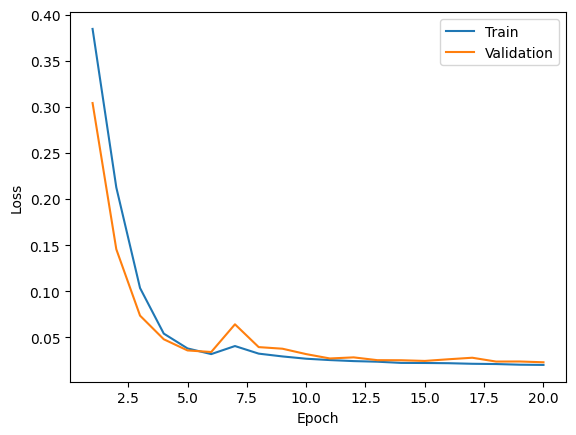

In [291]:
class_loss = dice_loss()
optim = torch.optim.Adam(net.parameters(), lr = 0.01)

losses = []
max_epochs = 20
for epoch in range(1, max_epochs+1):
    train_loss = train(net, train_dataloader, optim, class_loss, epoch)
    val_loss = val(net, val_dataloader, optim, class_loss, epoch)
    losses.append([train_loss, val_loss])

losses = np.array(losses).T
print(losses.shape)
its = np.linspace(1, max_epochs, max_epochs)

plt.figure()
plt.plot(its, losses[0,:])
plt.plot(its, losses[1,:])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'])

In [292]:
pred, true, test_loss, test_acc = predict(net, test_dataloader)

Test set: Average loss: 0.0224
Test set: Average Acc: 0.9816




and RUNet AX

In [293]:
X = centring(guys_X,2) 
Y = to_one_hot(guys_Y)
#Y = to_one_hot_single(guys_Y,1)

In [294]:
X.shape

(317, 1, 40, 128, 128)

In [295]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y,test_size = 0.1)

In [296]:
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size = 0.1)

In [297]:
train_dataset = integer_numpy_dataset(X_train, Y_train) #as RUNet takes 3D tensors as input
val_dataset = integer_numpy_dataset(X_val, Y_val)

In [298]:
train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True, drop_last=True)
val_dataloader = DataLoader(val_dataset, batch_size=16, shuffle=False, drop_last=True)

In [299]:
test_dataset = integer_numpy_dataset(X_test, Y_test)
test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=False, drop_last=True)

In [300]:
Y_train.shape

(256, 2, 40, 128, 128)

In [301]:
train_dataset[4][0].shape

torch.Size([1, 40, 128, 128])

In [302]:
net = RUNet(in_channels=1, init_features=4, out_channels=2, token_shape = (40,128),ax=2).to(device)
print('Trainable params: ', net.parameters())

Trainable params:  <generator object Module.parameters at 0x00000243042DEA40>


Train Epoch: 1 [16/256 (6%)]	Loss: 0.524885

Training set: Average loss: 0.4171
Time taken for epoch =  16.31203007698059
Validation set: Average loss: 0.2461


Train Epoch: 2 [16/256 (6%)]	Loss: 0.322369

Training set: Average loss: 0.2886
Time taken for epoch =  9.499675512313843
Validation set: Average loss: 0.2673


Train Epoch: 3 [16/256 (6%)]	Loss: 0.353993

Training set: Average loss: 0.4479
Time taken for epoch =  9.420023679733276
Validation set: Average loss: 0.4040


Train Epoch: 4 [16/256 (6%)]	Loss: 0.419255

Training set: Average loss: 0.4093
Time taken for epoch =  9.45809555053711
Validation set: Average loss: 0.3921


Train Epoch: 5 [16/256 (6%)]	Loss: 0.413789

Training set: Average loss: 0.4100
Time taken for epoch =  9.631360530853271
Validation set: Average loss: 0.3917


Train Epoch: 6 [16/256 (6%)]	Loss: 0.412235

Training set: Average loss: 0.4118
Time taken for epoch =  9.46036958694458
Validation set: Average loss: 0.3998


Train Epoch: 7 [16/256 (6%)]	Loss: 0

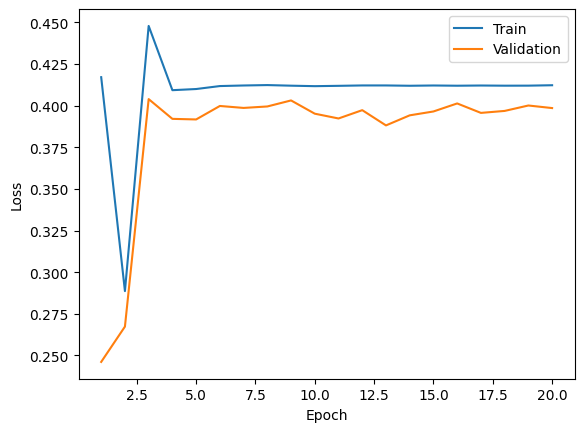

In [303]:
class_loss = dice_loss()
optim = torch.optim.Adam(net.parameters(), lr = 0.01)

losses = []
max_epochs = 20
for epoch in range(1, max_epochs+1):
    train_loss = train(net, train_dataloader, optim, class_loss, epoch)
    val_loss = val(net, val_dataloader, optim, class_loss, epoch)
    losses.append([train_loss, val_loss])

losses = np.array(losses).T
print(losses.shape)
its = np.linspace(1, max_epochs, max_epochs)

plt.figure()
plt.plot(its, losses[0,:])
plt.plot(its, losses[1,:])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'])

In [304]:
pred, true, test_loss, test_acc = predict(net, test_dataloader)

Test set: Average loss: 0.4077
Test set: Average Acc: 0.6188




and RUNet COR

In [305]:
X = centring(guys_X,3) 
Y = to_one_hot(guys_Y)
#Y = to_one_hot_single(guys_Y,1)

In [306]:
X.shape

(317, 1, 40, 128, 128)

In [307]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y,test_size = 0.1)

In [308]:
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size = 0.1)

In [309]:
train_dataset = integer_numpy_dataset(X_train, Y_train) #as RUNet takes 3D tensors as input
val_dataset = integer_numpy_dataset(X_val, Y_val)

In [310]:
train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True, drop_last=True)
val_dataloader = DataLoader(val_dataset, batch_size=16, shuffle=False, drop_last=True)

In [311]:
test_dataset = integer_numpy_dataset(X_test, Y_test)
test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=False, drop_last=True)

In [312]:
Y_train.shape

(256, 2, 40, 128, 128)

In [313]:
train_dataset[4][0].shape

torch.Size([1, 40, 128, 128])

In [314]:
net = RUNet(in_channels=1, init_features=4, out_channels=2, token_shape = (40,128),ax=3).to(device)
print('Trainable params: ', net.parameters())

Trainable params:  <generator object Module.parameters at 0x00000243042DF220>


Train Epoch: 1 [16/256 (6%)]	Loss: 0.490350

Training set: Average loss: 0.4251
Time taken for epoch =  10.671103239059448
Validation set: Average loss: 0.3532


Train Epoch: 2 [16/256 (6%)]	Loss: 0.370696

Training set: Average loss: 0.3565
Time taken for epoch =  9.736297130584717
Validation set: Average loss: 0.4014


Train Epoch: 3 [16/256 (6%)]	Loss: 0.355882

Training set: Average loss: 0.3402
Time taken for epoch =  9.728503704071045
Validation set: Average loss: 0.4414


Train Epoch: 4 [16/256 (6%)]	Loss: 0.315187

Training set: Average loss: 0.3070
Time taken for epoch =  9.773387670516968
Validation set: Average loss: 0.4204


Train Epoch: 5 [16/256 (6%)]	Loss: 0.289924

Training set: Average loss: 0.2881
Time taken for epoch =  9.782258033752441
Validation set: Average loss: 0.4222


Train Epoch: 6 [16/256 (6%)]	Loss: 0.283903

Training set: Average loss: 0.2760
Time taken for epoch =  9.79091501235962
Validation set: Average loss: 0.4521


Train Epoch: 7 [16/256 (6%)]	Loss:

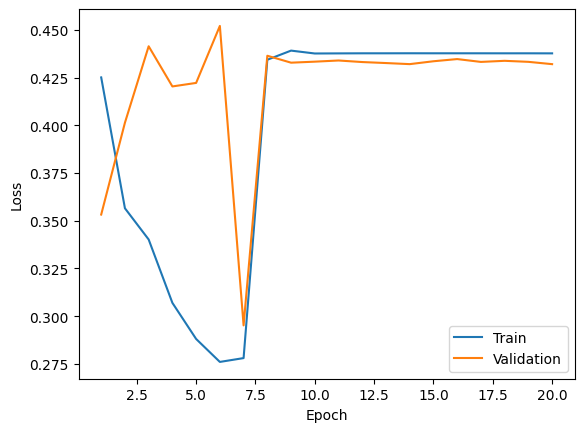

In [315]:
class_loss = dice_loss()
optim = torch.optim.Adam(net.parameters(), lr = 0.01)

losses = []
max_epochs = 20
for epoch in range(1, max_epochs+1):
    train_loss = train(net, train_dataloader, optim, class_loss, epoch)
    val_loss = val(net, val_dataloader, optim, class_loss, epoch)
    losses.append([train_loss, val_loss])

losses = np.array(losses).T
print(losses.shape)
its = np.linspace(1, max_epochs, max_epochs)

plt.figure()
plt.plot(its, losses[0,:])
plt.plot(its, losses[1,:])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'])

In [316]:
pred, true, test_loss, test_acc = predict(net, test_dataloader)

Test set: Average loss: 0.4296
Test set: Average Acc: 0.5943




3D

In [317]:
X = centring(guys_X) 
Y = to_one_hot(guys_Y)
#Y = to_one_hot_single(guys_Y,1)

In [318]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y,test_size = 0.1)

In [319]:
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size = 0.1)

In [320]:
train_dataset = integer_numpy_dataset(X_train, Y_train) #as RUNet takes 3D tensors as input
val_dataset = integer_numpy_dataset(X_val, Y_val)

In [321]:
train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True, drop_last=True)
val_dataloader = DataLoader(val_dataset, batch_size=16, shuffle=False, drop_last=True)

In [322]:
test_dataset = integer_numpy_dataset(X_test, Y_test)
test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=False, drop_last=True)

In [323]:
Y_train.shape

(256, 2, 40, 128, 128)

In [324]:
train_dataset[4][0].shape

torch.Size([1, 40, 128, 128])

In [325]:
net = UNet_3D(in_channels=1, init_features=4, out_channels=2).to(device)
print('Trainable params: ', net.parameters())

Trainable params:  <generator object Module.parameters at 0x00000243042DFAE0>


Train Epoch: 1 [16/256 (6%)]	Loss: 0.513869

Training set: Average loss: 0.3230
Time taken for epoch =  16.162790060043335
Validation set: Average loss: 0.2866


Train Epoch: 2 [16/256 (6%)]	Loss: 0.217074

Training set: Average loss: 0.1587
Time taken for epoch =  14.499919891357422
Validation set: Average loss: 0.1000


Train Epoch: 3 [16/256 (6%)]	Loss: 0.100735

Training set: Average loss: 0.0751
Time taken for epoch =  14.470956087112427
Validation set: Average loss: 0.0501


Train Epoch: 4 [16/256 (6%)]	Loss: 0.051782

Training set: Average loss: 0.0446
Time taken for epoch =  14.527214288711548
Validation set: Average loss: 0.0396


Train Epoch: 5 [16/256 (6%)]	Loss: 0.034850

Training set: Average loss: 0.0342
Time taken for epoch =  14.552234888076782
Validation set: Average loss: 0.0342


Train Epoch: 6 [16/256 (6%)]	Loss: 0.037388

Training set: Average loss: 0.0306
Time taken for epoch =  14.66132402420044
Validation set: Average loss: 0.0329


Train Epoch: 7 [16/256 (6%)]	

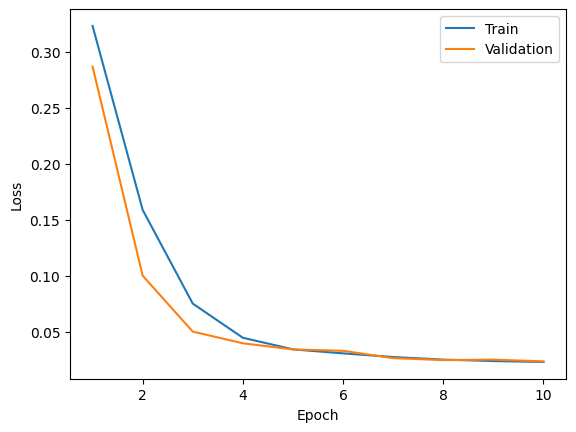

In [326]:
class_loss = dice_loss()
optim = torch.optim.Adam(net.parameters(), lr = 0.01)

losses = []
max_epochs = 10
for epoch in range(1, max_epochs+1):
    train_loss = train(net, train_dataloader, optim, class_loss, epoch)
    val_loss = val(net, val_dataloader, optim, class_loss, epoch)
    losses.append([train_loss, val_loss])

losses = np.array(losses).T
print(losses.shape)
its = np.linspace(1, max_epochs, max_epochs)

plt.figure()
plt.plot(its, losses[0,:])
plt.plot(its, losses[1,:])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'])

In [327]:
pred, true, test_loss, test_acc = predict(net, test_dataloader)

Test set: Average loss: 0.0236
Test set: Average Acc: 0.9819




fragility

In [328]:
X = centring(guys_X,1)[:,:,:,60,:]
Y = to_one_hot(guys_Y)[:,:,:,60,:]
#Y = np.expand_dims(to_one_hot_single(guys_Y,1)[:,:,0,:,:],2)

In [182]:
X_diff = centring(guys_X,1)[:,:,:,80,:]
Y_diff = to_one_hot(guys_Y)[:,:,:,80,:]

In [183]:
X.shape

(317, 1, 40, 128)

In [184]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y,test_size = 0.1)

In [185]:
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size = 0.1)

In [186]:
train_dataset = integer_numpy_dataset(X_train, Y_train)
val_dataset = integer_numpy_dataset(X_val, Y_val)

In [187]:
train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True, drop_last=True)
val_dataloader = DataLoader(val_dataset, batch_size=16, shuffle=False, drop_last=True)

In [188]:
test_dataset = integer_numpy_dataset(X_diff, Y_diff)
test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=False, drop_last=True)

In [189]:
Y_train.shape

(256, 2, 40, 128)

In [190]:
train_dataset[20][0].shape

torch.Size([1, 40, 128])

In [191]:
net = UNet(in_channels=1, init_features=4, out_channels=2).to(device)
print('Trainable params: ', net.parameters())

Trainable params:  <generator object Module.parameters at 0x000001B159490D60>


FC frag

In [244]:
X = centring(guys_X,1)[:,:,:,60,:]
Y = to_one_hot(guys_Y)[:,:,:,60,:]
#Y = np.expand_dims(to_one_hot_single(guys_Y,1)[:,:,0,:,:],2)

In [245]:
X_diff = centring(guys_X,1)[:,:,:,80,:]
Y_diff = to_one_hot(guys_Y)[:,:,:,80,:]

In [246]:
X.shape

(317, 1, 40, 128)

In [247]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y,test_size = 0.1)

In [248]:
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size = 0.1)

In [249]:
train_dataset = integer_numpy_dataset(X_train, Y_train)
val_dataset = integer_numpy_dataset(X_val, Y_val)

In [250]:
train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True, drop_last=True)
val_dataloader = DataLoader(val_dataset, batch_size=16, shuffle=False, drop_last=True)

In [251]:
test_dataset = integer_numpy_dataset(X_diff, Y_diff)
test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=False, drop_last=True)

In [252]:
Y_train.shape

(256, 2, 40, 128)

In [253]:
train_dataset[20][0].shape

torch.Size([1, 40, 128])

In [254]:
net = FCNet(in_dim=(40,128)).to(device)
print('Trainable params: ', net.parameters())

Trainable params:  <generator object Module.parameters at 0x000001B1E51ADD90>


pretrained RUNet

In [18]:
X = centring(guys_X,1)
Y = to_one_hot(guys_Y)
#Y = np.expand_dims(to_one_hot_single(guys_Y,1)[:,:,0,:,:],2)

In [19]:
X.shape

(317, 1, 40, 128, 128)

In [20]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y,test_size = 0.1)

In [21]:
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size = 0.1)

In [22]:
train_dataset = numpy_dataset_frac(X_train, Y_train,1,"simpru")
val_dataset = numpy_dataset_frac(X_val, Y_val,1,"simpru")

In [23]:
train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True, drop_last=True)
val_dataloader = DataLoader(val_dataset, batch_size=16, shuffle=False, drop_last=True)

In [24]:
test_dataset = numpy_dataset_frac(X_test, Y_test,1,"simpru")
test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=False, drop_last=True)

In [25]:
Y_train.shape

(256, 2, 40, 128, 128)

In [26]:
train_dataset[20][0].shape

torch.Size([3, 128, 128])

In [27]:
net = UNet(in_channels=3, init_features=4, out_channels=2).to(device)#train 3 layer net which takes previous output as stacked input
print('Trainable params: ', net.parameters())

Trainable params:  <generator object Module.parameters at 0x00000283FA8CD930>


In [39]:
train_dataset = integer_numpy_dataset(X_train, Y_train)
val_dataset = integer_numpy_dataset(X_val, Y_val)#typo causing bug >:(

In [40]:
train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True, drop_last=True)
val_dataloader = DataLoader(val_dataset, batch_size=16, shuffle=False, drop_last=True)

In [41]:
test_dataset = integer_numpy_dataset(X_test, Y_test,1)
test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=False, drop_last=True)

In [42]:
Y_train.shape

(256, 2, 40, 128, 128)

In [43]:
train_dataset[20][0].shape

torch.Size([1, 40, 128, 128])

In [44]:
val_dataset[20][0].shape

torch.Size([1, 40, 128, 128])

In [34]:
net = RUNet(in_channels=1, init_features=4, out_channels=2, pre_trained = net, token_shape = (128,128)).to(device)
print('Trainable params: ', net.parameters())

Trainable params:  <generator object Module.parameters at 0x00000286701F68F0>


In [45]:
net.token

torch.Size([2, 128, 128])

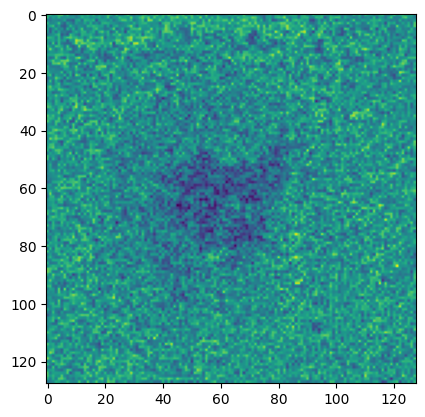

In [50]:
plt.imshow(net.token.detach().cpu().numpy()[0])

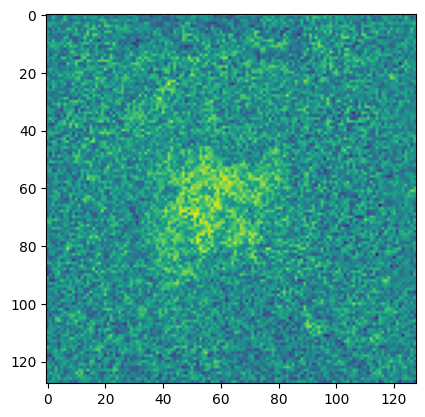

In [51]:
plt.imshow(net.token.detach().cpu().numpy()[1])

Train Epoch: 1 [16/256 (6%)]	Loss: 0.027189

Training set: Average loss: 0.0281
Time taken for epoch =  7.702521562576294
Validation set: Average loss: 0.0469


Train Epoch: 2 [16/256 (6%)]	Loss: 0.023845

Training set: Average loss: 0.0237
Time taken for epoch =  7.435661554336548
Validation set: Average loss: 0.0696


Train Epoch: 3 [16/256 (6%)]	Loss: 0.025236

Training set: Average loss: 0.0224
Time taken for epoch =  7.470903396606445
Validation set: Average loss: 0.0393


Train Epoch: 4 [16/256 (6%)]	Loss: 0.021221

Training set: Average loss: 0.0212
Time taken for epoch =  7.518442869186401
Validation set: Average loss: 0.0323


Train Epoch: 5 [16/256 (6%)]	Loss: 0.021346

Training set: Average loss: 0.0203
Time taken for epoch =  7.541708707809448
Validation set: Average loss: 0.0267


Train Epoch: 6 [16/256 (6%)]	Loss: 0.025069

Training set: Average loss: 0.0198
Time taken for epoch =  7.467883825302124
Validation set: Average loss: 0.0355


Train Epoch: 7 [16/256 (6%)]	Loss:

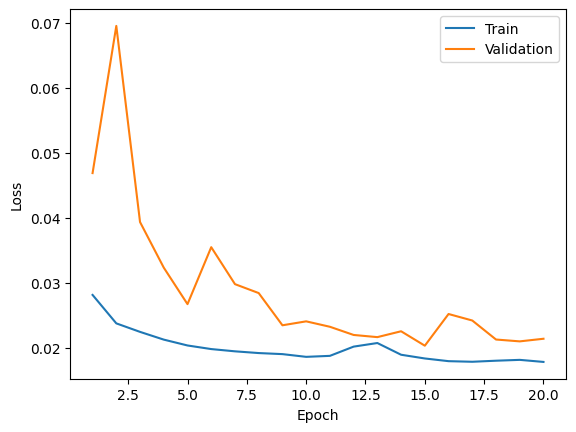

In [49]:
class_loss = dice_loss()
optim = torch.optim.Adam(net.parameters(), lr = 0.01)

losses = []
max_epochs = 20
for epoch in range(1, max_epochs+1):
    train_loss = train(net, train_dataloader, optim, class_loss, epoch)
    val_loss = val(net, val_dataloader, optim, class_loss, epoch)
    losses.append([train_loss, val_loss])

losses = np.array(losses).T
print(losses.shape)
its = np.linspace(1, max_epochs, max_epochs)

plt.figure()
plt.plot(its, losses[0,:])
plt.plot(its, losses[1,:])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'])

In [333]:
pred, true, test_loss, test_acc = predict(net, test_dataloader)

IndexError: too many indices for tensor of dimension 3

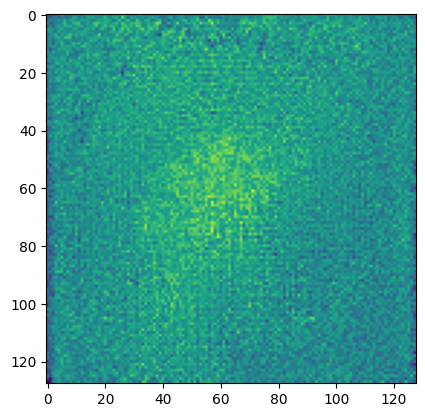

In [290]:
plt.imshow(net.token.detach().cpu().numpy()[0])

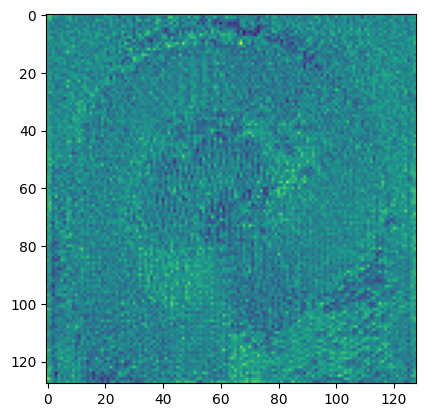

In [288]:
plt.imshow(net.token.detach().cpu().numpy()[1])

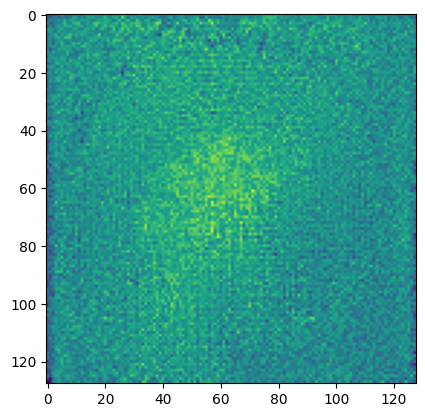

In [290]:
plt.imshow(net.token.detach().cpu().numpy()[0])

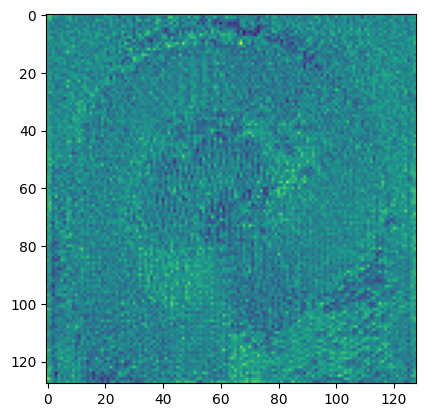

In [288]:
plt.imshow(net.token.detach().cpu().numpy()[1])

In [293]:
np.mean(net.token.detach().cpu().numpy()[1])#+net.token.detach().cpu().numpy()[0])

0.49720675

In [267]:
max(map(lambda x: np.max(x), pred))

0

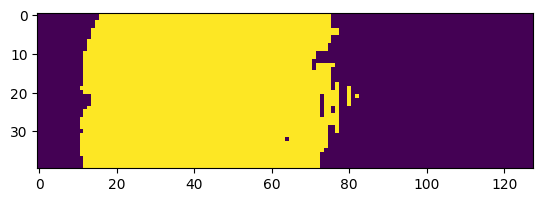

In [261]:
plt.imshow(true[0][0])

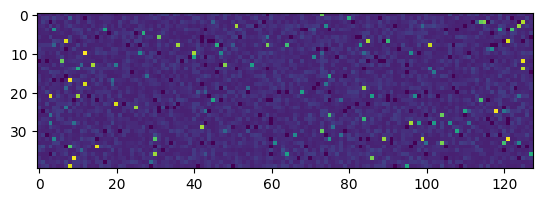

In [240]:
plt.imshow(net(test_dataset[0][0].to(device)).detach().cpu().numpy()[0][0])

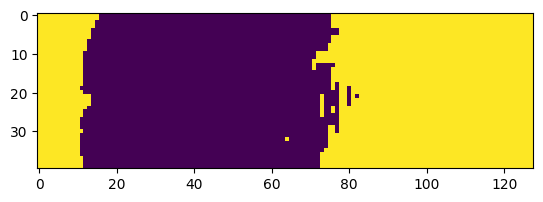

In [241]:
plt.imshow(test_dataset[0][1][0])

In [228]:
class_loss(test_dataset[0][1][0],test_dataset[15][1][0])

tensor(0.4923)

thalamus

Test set: Average loss: 0.0206 2D, sag
Test set: Average Acc: 0.9817

Test set: Average loss: 0.0913 2D, ax
Test set: Average Acc: 0.9773

Test set: Average loss: 0.0100 2.5D ax SUNet
Test set: Average Acc: 0.9934

Test set: Average loss: 0.0683 2.5D sag RUNet
Test set: Average Acc: 0.9983

Test set: Average loss: 0.0182
Test set: Average Acc: 0.9840

Test set: Average loss: 0.0453 3DNet
Test set: Average Acc: 0.9989

epochs taking twice as long rip

fragility

Test set: Average loss: 0.0775 (val is 0.014) sag trained on 0 test on 20
Test set: Average Acc: 0.9318

Test set: Average loss: 0.1021 (val is 0.0175)ax trained on coronal 40, tested on 20
Test set: Average Acc: 0.9006

FC

Test set: Average loss: 0.4
Test set: Average Acc: 0.4791

Training set: Average loss: 0.0022
Time taken for epoch =  0.12850594520568848
Validation set: Average loss: 0.0021

In [ ]:
for model in []

In [ ]:
plt.imshow(net.token[0].detach().cpu())

In [ ]:
plt.imshow(net.token[1].detach().cpu())

why are epoch numbers so low? incomplete training for some reason? nope just modulo 100


In [ ]:
net.eval()

In [ ]:
plt.imshow(net(torch.Tensor(np.expand_dims(centred[0],0)).to(device)).detach().cpu().numpy()[0][0][20])

In [ ]:
plt.imshow(y[0][0][20])

In [ ]:
torch.save(net.state_dict(), path+"/RUNet.pt")

In [ ]:
net(torch.reshape(torch.Tensor(centred[0][:,19:22,:,:]),(1,3,128,128)).to(device)).detach().cpu().numpy()[0][0].shape

In [ ]:
plt.imshow(net(torch.Tensor(np.expand_dims(centred[0][:,20,:,:],0)).to(device)).detach().cpu().numpy()[0][0])

In [ ]:
plt.imshow(y[0][0][20])

In [ ]:
plt.imshow(centred[0][0,20,:,:])

In [ ]:
sag_dataloader = DataLoader(integer_numpy_dataset(centred,y,1), batch_size=16, shuffle=True, drop_last=True)

In [ ]:
net = FCNet()#(token_shape=(128,128))#UNet(in_channels=3, init_features=4, out_channels=2)
net = net.to(device)
# Calculate the number of traininable params
print('Trainable params: ', net.parameters())

class_loss = dice_loss() # nn.BCELoss()
optim = torch.optim.SGD(FCnet.parameters(), lr = 0.01)

losses = []
max_epochs = 20
for epoch in range(1, max_epochs+1):
    train_loss = train(net, sag_dataloader, optim, class_loss, epoch)
    losses.append([train_loss])

losses = np.array(losses).T
print(losses.shape)
its = np.linspace(1, max_epochs, max_epochs)

plt.figure()
plt.plot(its, losses[0,:])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train'])

128*128

262133/16384

plt.imshow(guys_X[0][20])

plt.imshow(guys_Y[0][20])

plt.imshow(extra_Y[0][20])

plt.imshow(guys_X[0][:,60])

plt.imshow(guys_Y[0][:,60])

plt.imshow(extra_Y[0][:,60])

plt.imshow(guys_X[0][:,:,60])

plt.imshow(guys_Y[0][:,:,60])

plt.imshow(extra_Y[0][:,:,60])

np.min(ran)

np.min(centred)

plt.imshow(centred[0][0][:,0],vmin=-1.65, vmax=6.5)

plt.imshow(ran[0][0][:,0],vmin=-1.65, vmax=6.5)

plt.imshow(centred[0][0][0],vmin=-1.65, vmax=6.5)

centred[0][0][0]

ran[0][0][0]

plt.imshow(ran[0][0][0],vmin=-1.65, vmax=6.5)

centred = np.expand_dims(centring(guys_X,1),1)

ran = np.expand_dims(centring(guys_X),1)

centred.shape

x=torch.from_numpy(centred)[0][:,1,:,:]

x = torch.reshape(x,tupswap(x.shape,(0,1)))

x.shape

x[:].shape

y = to_one_hot(guys_Y)

y = to_one_hot_fewer(guys_Y,[1,2])

y.shape

plt.imshow(y[0][0][20])

plt.imshow(y[0][1][20])

plt.imshow(y[0][2][20])

plt.imshow(guys_Y[0][20])

plt.imshow(y[0][1][20])

#sag_DS = integer_numpy_dataset(centred,y,1)
#DS = integer_numpy_dataset(centred,y)
sag_sand_DS = numpy_dataset_frac(centred,y,1,"sandwich")

train_dataloader = DataLoader(DS, batch_size=4, shuffle=True, drop_last=True)